# Create a data product

Spatial signatures in Great Britain are released as a data product. 

This notebook takes the generated results and turn them into clean outputs.

In [ ]:
# we need the master version of dask geopandas that has sjoin and recent dask
!pip install git+https://github.com/geopandas/dask-geopandas.git

In [1]:
import pandas
import dask.dataframe
import dask
import geopandas
import dask_geopandas 

In [2]:
dask_geopandas.__version__

'v0.1.0a4+16.gf18ae2c'

## Signature geometry

We create an output with signature geometry and clear columns.

In [2]:
signatures = geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/signatures/signatures_combined_levels_orig.pq")
signatures.head()

,kmeans10gb,geometry,level2,signature_type
0,0,"POLYGON Z ((62220.000 798500.000 0.000, 62110....",0.0,0_0
1,0,"POLYGON Z ((63507.682 796515.169 0.000, 63471....",0.0,0_0
2,0,"POLYGON Z ((65953.174 802246.172 0.000, 65950....",0.0,0_0
3,0,"POLYGON Z ((67297.740 803435.800 0.000, 67220....",0.0,0_0
4,0,"POLYGON Z ((75760.000 852670.000 0.000, 75700....",0.0,0_0


In [3]:
types = {
    "0_0": "Countryside agriculture",
    "1_0": "Accessible suburbia",
    "3_0": "Open sprawl",
    "4_0": "Wild countryside",
    "5_0": "Warehouse/Park land",
    "6_0": "Gridded residential quarters",
    "7_0": "Urban buffer",
    "8_0": "Disconnected suburbia",
    "2_0": "Dense residential neighbourhoods",
    "2_1": "Connected residential neighbourhoods",
    "2_2": "Dense urban neighbourhoods",
    "9_0": "Local urbanity",
    "9_1": "Concentrated urbanity",
    "9_2": "Regional urbanity",
    "9_4": "Metropolitan urbanity",
    "9_5": "Hyper concentrated urbanity",
    "9_3": "outlier",
    "9_6": "outlier",
    "9_7": "outlier",
    "9_8": "outlier",
}

In [4]:
signatures["type"] = signatures.signature_type.map(types)
signatures["id"] = range(len(signatures))

In [5]:
signatures.head()

,kmeans10gb,geometry,level2,signature_type,type,id
0,0,"POLYGON Z ((62220.000 798500.000 0.000, 62110....",0.0,0_0,Countryside agriculture,0
1,0,"POLYGON Z ((63507.682 796515.169 0.000, 63471....",0.0,0_0,Countryside agriculture,1
2,0,"POLYGON Z ((65953.174 802246.172 0.000, 65950....",0.0,0_0,Countryside agriculture,2
3,0,"POLYGON Z ((67297.740 803435.800 0.000, 67220....",0.0,0_0,Countryside agriculture,3
4,0,"POLYGON Z ((75760.000 852670.000 0.000, 75700....",0.0,0_0,Countryside agriculture,4


In [6]:
signatures = signatures[["id", "type", "geometry"]]

In [7]:
signatures

,id,type,geometry
0,0,Countryside agriculture,"POLYGON Z ((62220.000 798500.000 0.000, 62110...."
1,1,Countryside agriculture,"POLYGON Z ((63507.682 796515.169 0.000, 63471...."
2,2,Countryside agriculture,"POLYGON Z ((65953.174 802246.172 0.000, 65950...."
3,3,Countryside agriculture,"POLYGON Z ((67297.740 803435.800 0.000, 67220...."
4,4,Countryside agriculture,"POLYGON Z ((75760.000 852670.000 0.000, 75700...."
...,...,...,...
96699,96699,outlier,"POLYGON ((323321.005 463795.416, 323319.842 46..."
96700,96700,outlier,"POLYGON ((325929.840 1008792.061, 325927.377 1..."
96701,96701,outlier,"POLYGON ((337804.770 1013422.583, 337800.122 1..."
96702,96702,outlier,"POLYGON ((422304.270 1147826.990, 422296.000 1..."


### Remove Z coordinates

Some polygons contain Z coordinates that are not needed.

In [8]:
import pygeos

In [9]:
signatures["geometry"] = pygeos.apply(signatures.geometry.values.data, lambda x: x, include_z=False)

In [10]:
signatures

,id,type,geometry
0,0,Countryside agriculture,"POLYGON ((62220.000 798500.000, 62110.000 7985..."
1,1,Countryside agriculture,"POLYGON ((63507.682 796515.169, 63471.097 7965..."
2,2,Countryside agriculture,"POLYGON ((65953.174 802246.172, 65950.620 8022..."
3,3,Countryside agriculture,"POLYGON ((67297.740 803435.800, 67220.289 8034..."
4,4,Countryside agriculture,"POLYGON ((75760.000 852670.000, 75700.000 8527..."
...,...,...,...
96699,96699,outlier,"POLYGON ((323321.005 463795.416, 323319.842 46..."
96700,96700,outlier,"POLYGON ((325929.840 1008792.061, 325927.377 1..."
96701,96701,outlier,"POLYGON ((337804.770 1013422.583, 337800.122 1..."
96702,96702,outlier,"POLYGON ((422304.270 1147826.990, 422296.000 1..."


## Cleanup sliver geometries

Remove artifacts caused by floating point imprecision in dissolving of ET cells into signature geometries.

In [ ]:
from shapely.geometry import Polygon

signatures_ddf = dask_geopandas.from_geopandas(signatures, npartitions=4)

def fix(gdf):
    new = []
    for poly in gdf.geometry:
        new.append(Polygon(shell=poly.exterior, holes=[i for i in poly.interiors if Polygon(i).area > 1]))
    return geopandas.GeoSeries(new, index=gdf.index, crs=gdf.crs)


signatures_ddf["geometry"] = signatures_ddf.map_partitions(fix, meta=geopandas.GeoSeries())

In [23]:
signatures.compute().to_file("spatial_signatures_GB.gpkg", driver="GPKG")

## Link data

We also need CSV summarising geometries, but since we want to use the original characters before contextualisation and standardisation, we need to join them to geometry.

### Harmonize Corine data.

In [24]:
import pyarrow.parquet as pq
import pandas as pd

columns = set()
for i in range(103):
    schema = pq.read_schema(f"../../urbangrammar_samba/spatial_signatures/functional/corine/corine_{i}.pq")
    for c in schema.names:
        columns.add(c)

for i in range(103):
    df = pd.read_parquet(f"../../urbangrammar_samba/spatial_signatures/functional/corine/corine_{i}.pq")
    missing = [c for c in columns if c not in df.columns]
    df[missing] = 0
    df.to_parquet(f"../../urbangrammar_samba/spatial_signatures/functional/corine/corine_{i}.pq")

### Join data

In [11]:
from dask.distributed import Client, LocalCluster
client = Client(LocalCluster(n_workers=8))
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 125.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37701,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 125.55 GiB
Comm: tcp://127.0.0.1:36115,Total threads: 2
Dashboard: http://127.0.0.1:37581/status,Memory: 15.69 GiB
Nanny: tcp://127.0.0.1:36133,


In [12]:
tessellation = dask_geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/tessellation/tess_*.pq")

/opt/conda/lib/python3.8/site-packages/dask_geopandas/io/parquet.py:83: FutureWarning: Assigning CRS to a GeoDataFrame without a geometry column is now deprecated and will not be supported in the future.
  meta = geopandas.GeoDataFrame(meta, crs=crs)


In [13]:
tessellation = dask_geopandas.from_dask_dataframe(tessellation[["hindex", "tessellation"]]).set_geometry("tessellation").explode()

In [14]:
tessellation["point"] = tessellation.representative_point()
tessellation = tessellation.set_geometry("point")

In [15]:
joined = dask_geopandas.sjoin(tessellation, signatures, op="within")

/opt/conda/lib/python3.8/site-packages/dask_geopandas/sjoin.py:50: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:27700

  meta = geopandas.sjoin(left._meta, right._meta, how=how, op=op)


In [16]:
%%time
joined[["hindex", "id", "type"]].to_parquet("../../urbangrammar_samba/spatial_signatures/signatures/hindex_to_type")

CPU times: user 17.1 s, sys: 3.16 s, total: 20.3 s
Wall time: 1min 33s


Second bit.

In [30]:
joined = dask.dataframe.read_parquet("../../urbangrammar_samba/spatial_signatures/signatures/hindex_to_type")

In [18]:
pop = dask.dataframe.read_parquet(f"../../urbangrammar_samba/spatial_signatures/functional/population/pop_*")
nl = dask.dataframe.read_parquet(f"../../urbangrammar_samba/spatial_signatures/functional/night_lights/nl_*")
workplace = dask.dataframe.read_parquet(f"../../urbangrammar_samba/spatial_signatures/functional/workplace/pop_*")
corine = dask.dataframe.read_parquet(f"../../urbangrammar_samba/spatial_signatures/functional/corine/corine_*.pq")
ndvi = dask.dataframe.read_parquet(f"../../urbangrammar_samba/functional_data/ndvi/ndvi_tess_*.pq")
pois = dask.dataframe.read_parquet(f"../../urbangrammar_samba/spatial_signatures/functional/accessibility/access_*.pq")
water = dask.dataframe.read_parquet(f'../../urbangrammar_samba/spatial_signatures/functional/water/water_*.pq')
retail_centres = dask.dataframe.read_parquet(f'../../urbangrammar_samba/spatial_signatures/functional/retail_centre/retail_*.pq')

In [21]:
function = dask.dataframe.multi.concat([pop, nl.drop(columns="hindex"), workplace.drop(columns="hindex"), corine.drop(columns="hindex"), ndvi.reset_index(drop=True), pois.drop(columns="hindex"), water.drop(columns="hindex"), retail_centres.drop(columns="hindex")], axis=1)

/opt/conda/lib/python3.8/site-packages/dask/dataframe/multi.py:1212: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


In [ ]:
%%time
function.to_parquet("../../urbangrammar_samba/spatial_signatures/functional/combined_raw")

Another bit

In [23]:
function = dask.dataframe.read_parquet("../../urbangrammar_samba/spatial_signatures/functional/combined_raw")

In [25]:
function

,hindex,population,night_lights,"A, B, D, E. Agriculture, energy and water",C. Manufacturing,F. Construction,"G, I. Distribution, hotels and restaurants","H, J. Transport and communication","K, L, M, N. Financial, real estate, professional and administrative activities","O,P,Q. Public administration, education and health","R, S, T, U. Other",Code_18_124,Code_18_211,Code_18_121,Code_18_421,Code_18_522,Code_18_142,Code_18_141,Code_18_112,Code_18_231,Code_18_311,Code_18_131,Code_18_123,Code_18_122,Code_18_512,Code_18_243,Code_18_313,Code_18_412,Code_18_321,Code_18_322,Code_18_324,Code_18_111,Code_18_423,Code_18_523,Code_18_133,Code_18_334,Code_18_132,Code_18_242,Code_18_411,Code_18_511,Code_18_312,Code_18_332,Code_18_521,Code_18_331,Code_18_244,Code_18_333,Code_18_222,mean,supermarkets_nearest,supermarkets_counts,listed_nearest,listed_counts,fhrs_nearest,fhrs_counts,culture_nearest,culture_counts,nearest_water,nearest_retail_centre
npartitions=103,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,float64,int64,float64,int64,float64,int64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [26]:
form = dask.dataframe.read_parquet("../../urbangrammar_samba/spatial_signatures/morphometrics/cells/cells_*.pq")
form

,hindex,tessellation,buildings,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,ssbCCM,ssbCCD,stbOri,sdcLAL,sdcAre,sscCCo,sscERI,stcOri,sicCAR,stbCeA,mtbAli,mtbNDi,mtcWNe,mdcAre,ltcWRE,ltbIBD,nodeID,sdsSPW,sdsSWD,sdsSPO,sdsLen,sssLin,ldsMSL,mtdDeg,lcdMes,linP3W,linP4W,linPDE,lcnClo,ldsCDL,xcnSCl,mtdMDi,lddNDe,linWID,edgeID_keys,edgeID_values,edgeID_primary,stbSAl,sddAre,sdsAre,sisBpM,misCel,mdsAre,lisCel,ldsAre,ltcRea,ltcAre,ldeAre,ldePer,lseCCo,lseERI,lseCWA,lteOri,lteWNB,lieWCe
npartitions=103,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [27]:
form = form.drop(columns=["tessellation", "buildings"])

In [49]:
data = form.merge(function, on="hindex", how="left")

In [52]:
%%time
data.to_parquet("../../urbangrammar_samba/spatial_signatures/data_combined_raw")

distributed.nanny - WARNING - Worker process still alive after 3 seconds, killing


CPU times: user 7min 38s, sys: 44.6 s, total: 8min 23s
Wall time: 37min 11s


In [53]:
data = dask.dataframe.read_parquet("../../urbangrammar_samba/spatial_signatures/data_combined_raw")

In [54]:
merged = joined.merge(data, on="hindex", how="left")

With all data merged together, we can create summaries using groupby.

In [55]:
per_geometry = merged.drop(columns=["hindex", "type"]).groupby("id").mean()
per_type = merged.drop(columns=["hindex", "id"]).groupby("type").mean()

In [56]:
%%time
per_type, per_geometry = dask.compute(per_type, per_geometry)

CPU times: user 1min 1s, sys: 5.53 s, total: 1min 7s
Wall time: 3min 42s


In [58]:
per_type

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,ssbCCM,ssbCCD,...,supermarkets_nearest,supermarkets_counts,listed_nearest,listed_counts,fhrs_nearest,fhrs_counts,culture_nearest,culture_counts,nearest_water,nearest_retail_centre
type,,,,,,,,,,,,,,,,,,,,,
Accessible suburbia,176.949135,53.902697,0.476838,0.534856,4.253845,0.775272,0.987707,0.642271,9.604873,0.364329,...,828.822261,1.890519,744.223994,11.273578,218.460768,334.434991,5384.638746,0.059113,542.613661,849.447871
Connected residential neighbourhoods,272.522220,69.119967,1.069872,0.480941,4.445515,1.466426,0.979415,0.555468,12.406840,0.707494,...,679.958940,2.855980,596.613654,24.279146,152.479922,692.664050,3946.052517,0.129197,555.964942,536.469155
Countryside agriculture,204.100400,56.048984,0.505831,0.506275,4.371156,0.809087,0.977789,0.600065,9.791869,0.556915,...,4751.226429,0.089042,557.936276,11.223066,725.690643,44.465529,13156.203765,0.003804,304.488181,4943.972107
Dense residential neighbourhoods,375.598290,80.558473,2.127340,0.472554,4.694714,1.863620,0.969912,0.557054,13.961420,1.070784,...,661.765594,3.127412,506.614715,37.474705,144.021617,860.927102,3497.511181,0.259194,483.124139,421.093530
Dense urban neighbourhoods,588.359559,107.362849,5.034084,0.435714,5.208242,3.278419,0.950431,0.519821,17.999101,1.877968,...,587.276810,4.436632,350.890339,62.783422,106.084358,1568.443597,2287.432199,0.476118,528.850109,224.326713
Disconnected suburbia,212.713958,61.631662,0.519372,0.491588,4.347900,1.019293,0.981779,0.573786,11.114826,0.539407,...,761.858373,2.067315,729.608517,24.181257,217.945624,342.081722,5831.523433,0.077958,523.050240,725.573382
Distilled urbanity,3713.379427,376.300388,159.087608,0.425186,12.484667,18.589482,0.776950,0.594314,35.927794,9.034682,...,229.903096,22.510563,31.732228,685.156338,16.219050,6297.607746,702.750880,10.392254,565.248203,29.803442
Gridded residential quarters,283.892607,69.667245,0.749026,0.491754,4.506685,1.663151,0.976842,0.584548,12.411805,0.799002,...,577.683974,3.409903,516.197376,31.771826,129.244204,1081.376510,4094.915253,0.240503,522.087434,445.518972
Hyper distilled urbanity,3358.099586,330.818576,90.819544,0.446292,9.273438,22.513954,0.802892,0.617669,37.220199,7.696910,...,324.416312,18.791045,69.749236,1142.567164,14.101269,9213.145522,351.325110,34.197761,759.604208,32.544669


In [57]:
per_geometry

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,ssbCCM,ssbCCD,...,supermarkets_nearest,supermarkets_counts,listed_nearest,listed_counts,fhrs_nearest,fhrs_counts,culture_nearest,culture_counts,nearest_water,nearest_retail_centre
id,,,,,,,,,,,,,,,,,,,,,
0,129.933434,45.146514,0.202279,0.540968,4.172237,0.524401,0.993543,0.622563,8.027774,0.234288,...,1444.935973,0.454774,890.196235,3.572864,341.152792,77.364322,NaN,0.0,136.483329,93403.761607
4,258.461742,65.650654,5.278706,0.500917,4.376384,0.558092,0.975591,0.571528,11.094158,0.675784,...,9034.336389,0.000000,736.182262,1.718412,642.509775,126.115523,NaN,0.0,139.419780,58846.096367
9,122.655396,46.888304,0.000000,0.509570,4.336957,0.606492,0.981817,0.578105,8.168939,0.342824,...,NaN,0.000000,112.232624,4.935484,309.115193,61.000000,NaN,0.0,80.087762,4762.653237
11,190.308946,59.022824,0.764543,0.494519,4.541985,0.997673,0.967397,0.598092,10.134862,0.665047,...,NaN,0.000000,281.289369,8.043478,198.296841,4.326087,NaN,0.0,74.377682,4378.879114
14,146.477816,50.308964,0.229756,0.509439,4.382090,0.769455,0.974591,0.607979,8.836870,0.504590,...,2296.657968,0.023599,519.019717,7.519174,281.737308,24.020649,NaN,0.0,199.544381,1698.769041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,967.354980,1.000000,733.508972,18.000000,294.217987,62.000000,4342.378906,0.0,0.000000,731.905179
94853,542.697500,98.334230,0.000000,0.518628,4.000000,0.078285,0.999855,0.516309,18.248347,0.009636,...,547.687012,3.000000,97.226997,77.000000,112.362999,1346.000000,1062.750000,1.0,160.527776,213.305247
94892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,457.170990,5.000000,0.000000,515.000000,38.470001,2364.000000,401.411011,2.0,410.039048,0.000000


## Rename columns

In [2]:
coded = {
    'population': 'func_population',
    'night_lights': 'func_night_lights',
    'A, B, D, E. Agriculture, energy and water': 'func_workplace_abde',
    'C. Manufacturing': 'func_workplace_c',
    'F. Construction': 'func_workplace_f',
    'G, I. Distribution, hotels and restaurants': 'func_workplace_gi',
    'H, J. Transport and communication': 'func_workplace_hj',
    'K, L, M, N. Financial, real estate, professional and administrative activities': 'func_workplace_klmn',
    'O,P,Q. Public administration, education and health': 'func_workplace_opq',
    'R, S, T, U. Other': 'func_workplace_rstu',
    'Code_18_124': 'func_corine_124',
    'Code_18_211': 'func_corine_211',
    'Code_18_121': 'func_corine_121',
    'Code_18_421': 'func_corine_421',
    'Code_18_522': 'func_corine_522',
    'Code_18_142': 'func_corine_142',
    'Code_18_141': 'func_corine_141',
    'Code_18_112': 'func_corine_112',
    'Code_18_231': 'func_corine_231',
    'Code_18_311': 'func_corine_311',
    'Code_18_131': 'func_corine_131',
    'Code_18_123': 'func_corine_123',
    'Code_18_122': 'func_corine_122',
    'Code_18_512': 'func_corine_512',
    'Code_18_243': 'func_corine_243',
    'Code_18_313': 'func_corine_313',
    'Code_18_412': 'func_corine_412',
    'Code_18_321': 'func_corine_321',
    'Code_18_322': 'func_corine_322',
    'Code_18_324': 'func_corine_324',
    'Code_18_111': 'func_corine_111',
    'Code_18_423': 'func_corine_423',
    'Code_18_523': 'func_corine_523',
    'Code_18_312': 'func_corine_312',
    'Code_18_133': 'func_corine_133',
    'Code_18_333': 'func_corine_333',
    'Code_18_332': 'func_corine_332',
    'Code_18_411': 'func_corine_411',
    'Code_18_132': 'func_corine_132',
    'Code_18_222': 'func_corine_222',
    'Code_18_242': 'func_corine_242',
    'Code_18_331': 'func_corine_331',
    'Code_18_511': 'func_corine_511',
    'Code_18_334': 'func_corine_334',
    'Code_18_244': 'func_corine_244',
    'Code_18_521': 'func_corine_521',
    'mean': 'ndvi',
    'supermarkets_nearest': 'func_supermarkets_nearest',
    'supermarkets_counts': 'func_supermarkets_counts',
    'listed_nearest': 'func_listed_nearest',
    'listed_counts': 'func_listed_counts',
    'fhrs_nearest': 'func_fhrs_nearest',
    'fhrs_counts': 'func_fhrs_counts',
    'culture_nearest': 'func_culture_nearest',
    'culture_counts': 'func_culture_counts',
    'nearest_water': 'func_water_nearest',
    'nearest_retail_centre': 'func_retail_centrenearest',
    'sdbAre': 'form_sdbAre',
    'sdbPer': 'form_sdbPer',
    'sdbCoA': 'form_sdbCoA',
    'ssbCCo': 'form_ssbCCo',
    'ssbCor': 'form_ssbCor',
    'ssbSqu': 'form_ssbSqu',
    'ssbERI': 'form_ssbERI',
    'ssbElo': 'form_ssbElo',
    'ssbCCM': 'form_ssbCCM',
    'ssbCCD': 'form_ssbCCD',
    'stbOri': 'form_stbOri',
    'sdcLAL': 'form_sdcLAL',
    'sdcAre': 'form_sdcAre',
    'sscCCo': 'form_sscCCo',
    'sscERI': 'form_sscERI',
    'stcOri': 'form_stcOri',
    'sicCAR': 'form_sicCAR',
    'stbCeA': 'form_stbCeA',
    'mtbAli': 'form_mtbAli',
    'mtbNDi': 'form_mtbNDi',
    'mtcWNe': 'form_mtcWNe',
    'mdcAre': 'form_mdcAre',
    'ltcWRE': 'form_ltcWRE',
    'ltbIBD': 'form_ltbIBD',
    'sdsSPW': 'form_sdsSPW',
    'sdsSWD': 'form_sdsSWD',
    'sdsSPO': 'form_sdsSPO',
    'sdsLen': 'form_sdsLen',
    'sssLin': 'form_sssLin',
    'ldsMSL': 'form_ldsMSL',
    'mtdDeg': 'form_mtdDeg',
    'lcdMes': 'form_lcdMes',
    'linP3W': 'form_linP3W',
    'linP4W': 'form_linP4W',
    'linPDE': 'form_linPDE',
    'lcnClo': 'form_lcnClo',
    'ldsCDL': 'form_ldsCDL',
    'xcnSCl': 'form_xcnSCl',
    'mtdMDi': 'form_mtdMDi',
    'lddNDe': 'form_lddNDe',
    'linWID': 'form_linWID',
    'stbSAl': 'form_stbSAl',
    'sddAre': 'form_sddAre',
    'sdsAre': 'form_sdsAre',
    'sisBpM': 'form_sisBpM',
    'misCel': 'form_misCel',
    'mdsAre': 'form_mdsAre',
    'lisCel': 'form_lisCel',
    'ldsAre': 'form_ldsAre',
    'ltcRea': 'form_ltcRea',
    'ltcAre': 'form_ltcAre',
    'ldeAre': 'form_ldeAre',
    'ldePer': 'form_ldePer',
    'lseCCo': 'form_lseCCo',
    'lseERI': 'form_lseERI',
    'lseCWA': 'form_lseCWA',
    'lteOri': 'form_lteOri',
    'lteWNB': 'form_lteWNB',
    'lieWCe': 'form_lieWCe',
}

In [3]:
key = {
    'func_population': 'Population',
    'func_night_lights': 'Night lights',
    'func_workplace_abde': 'Workplace population [Agriculture, energy and water]',
    'func_workplace_c': 'Workplace population [Manufacturing]',
    'func_workplace_f': 'Workplace population [Construction]',
    'func_workplace_gi': 'Workplace population [Distribution, hotels and restaurants]',
    'func_workplace_hj': 'Workplace population [Transport and communication]',
    'func_workplace_klmn': 'Workplace population [Financial, real estate, professional and administrative activities]',
    'func_workplace_opq': 'Workplace population [Public administration, education and health]',
    'func_workplace_rstu': 'Workplace population [Other]',
    'func_corine_124': 'Land cover [Airports]',
    'func_corine_211': 'Land cover [Non-irrigated arable land]',
    'func_corine_121': 'Land cover [Industrial or commercial units]',
    'func_corine_421': 'Land cover [Salt marshes]',
    'func_corine_522': 'Land cover [Estuaries]',
    'func_corine_142': 'Land cover [Sport and leisure facilities]',
    'func_corine_141': 'Land cover [Green urban areas]',
    'func_corine_112': 'Land cover [Discontinuous urban fabric]',
    'func_corine_231': 'Land cover [Pastures]',
    'func_corine_311': 'Land cover [Broad-leaved forest]',
    'func_corine_131': 'Land cover [Mineral extraction sites]',
    'func_corine_123': 'Land cover [Port areas]',
    'func_corine_122': 'Land cover [Road and rail networks and associated land]',
    'func_corine_512': 'Land cover [Water bodies]',
    'func_corine_243': 'Land cover [Land principally occupied by agriculture, with significant areas of natural vegetation]',
    'func_corine_313': 'Land cover [Mixed forest]',
    'func_corine_412': 'Land cover [Peat bogs]',
    'func_corine_321': 'Land cover [Natural grasslands]',
    'func_corine_322': 'Land cover [Moors and heathland]',
    'func_corine_324': 'Land cover [Transitional woodland-shrub]',
    'func_corine_111': 'Land cover [Continuous urban fabric]',
    'func_corine_423': 'Land cover [Intertidal flats]',
    'func_corine_523': 'Land cover [Sea and ocean]',
    'func_corine_312': 'Land cover [Coniferous forest]',
    'func_corine_133': 'Land cover [Construction sites]',
    'func_corine_333': 'Land cover [Sparsely vegetated areas]',
    'func_corine_332': 'Land cover [Bare rocks]',
    'func_corine_411': 'Land cover [Inland marshes]',
    'func_corine_132': 'Land cover [Dump sites]',
    'func_corine_222': 'Land cover [Fruit trees and berry plantations]',
    'func_corine_242': 'Land cover [Complex cultivation patterns]',
    'func_corine_331': 'Land cover [Beaches, dunes, sands]',
    'func_corine_511': 'Land cover [Water courses]',
    'func_corine_334': 'Land cover [Burnt areas]',
    'func_corine_244': 'Land cover [Agro-forestry areas]',
    'func_corine_521': 'Land cover [Coastal lagoons]',
    'ndvi': 'NDVI',
    'func_supermarkets_nearest': 'Supermarkets [distance to nearest]',
    'func_supermarkets_counts': 'Supermarkets [counts within 1200m]',
    'func_listed_nearest': 'Listed buildings [distance to nearest]',
    'func_listed_counts': 'Listed buildings [counts within 1200m]',
    'func_fhrs_nearest': 'FHRS points [distance to nearest]',
    'func_fhrs_counts': 'FHRS points [counts within 1200m]',
    'func_culture_nearest': 'Cultural venues [distance to nearest]',
    'func_culture_counts': 'Cultural venues [counts within 1200m]',
    'func_water_nearest': 'Water bodies [distance to nearest]',
    'func_retail_centrenearest': 'Retail centres [distance to nearest]',
    'form_sdbAre': 'area of building',
    'form_sdbPer': 'perimeter of building',
    'form_sdbCoA': 'courtyard area of building',
    'form_ssbCCo': 'circular compactness of building',
    'form_ssbCor': 'corners of building',
    'form_ssbSqu': 'squareness of building',
    'form_ssbERI': 'equivalent rectangular index of building',
    'form_ssbElo': 'elongation of building',
    'form_ssbCCM': 'centroid - corner mean distance of building',
    'form_ssbCCD': 'centroid - corner distance deviation of building',
    'form_stbOri': 'orientation of building',
    'form_sdcLAL': 'longest axis length of ETC',
    'form_sdcAre': 'area of ETC',
    'form_sscCCo': 'circular compactness of ETC',
    'form_sscERI': 'equivalent rectangular index of ETC',
    'form_stcOri': 'orientation of ETC',
    'form_sicCAR': 'covered area ratio of ETC',
    'form_stbCeA': 'cell alignment of building',
    'form_mtbAli': 'alignment of neighbouring buildings',
    'form_mtbNDi': 'mean distance between neighbouring buildings',
    'form_mtcWNe': 'perimeter-weighted neighbours of ETC',
    'form_mdcAre': 'area covered by neighbouring cells',
    'form_ltcWRE': 'weighted reached enclosures of ETC',
    'form_ltbIBD': 'mean inter-building distance',
    'form_sdsSPW': 'width of street profile',
    'form_sdsSWD': 'width deviation of street profile',
    'form_sdsSPO': 'openness of street profile',
    'form_sdsLen': 'length of street segment',
    'form_sssLin': 'linearity of street segment',
    'form_ldsMSL': 'mean segment length within 3 steps',
    'form_mtdDeg': 'node degree of junction',
    'form_lcdMes': 'local meshedness of street network',
    'form_linP3W': 'local proportion of 3-way intersections of street network',
    'form_linP4W': 'local proportion of 4-way intersections of street network',
    'form_linPDE': 'local proportion of cul-de-sacs of street network',
    'form_lcnClo': 'local closeness of street network',
    'form_ldsCDL': 'local cul-de-sac length of street network',
    'form_xcnSCl': 'square clustering of street network',
    'form_mtdMDi': 'mean distance to neighbouring nodes of street network',
    'form_lddNDe': 'local node density of street network',
    'form_linWID': 'local degree weighted node density of street network',
    'form_stbSAl': 'street alignment of building',
    'form_sddAre': 'area covered by node-attached ETCs',
    'form_sdsAre': 'area covered by edge-attached ETCs',
    'form_sisBpM': 'buildings per meter of street segment',
    'form_misCel': 'reached ETCs by neighbouring segments',
    'form_mdsAre': 'reached area by neighbouring segments',
    'form_lisCel': 'reached ETCs by local street network',
    'form_ldsAre': 'reached area by local street network',
    'form_ltcRea': 'reached ETCs by tessellation contiguity',
    'form_ltcAre': 'reached area by tessellation contiguity',
    'form_ldeAre': 'area of enclosure',
    'form_ldePer': 'perimeter of enclosure',
    'form_lseCCo': 'circular compactness of enclosure',
    'form_lseERI': 'equivalent rectangular index of enclosure',
    'form_lseCWA': 'compactness-weighted axis of enclosure',
    'form_lteOri': 'orientation of enclosure',
    'form_lteWNB': 'perimeter-weighted neighbours of enclosure',
    'form_lieWCe': 'area-weighted ETCs of enclosure',
}

Assing new column names

In [81]:
per_type = per_type.rename(columns=coded)

In [3]:
per_type.drop("outlier").to_csv("per_type.csv")

In [84]:
per_geometry = per_geometry.rename(columns=coded)

In [85]:
per_geometry.to_csv("per_geometry.csv")

In [90]:
pandas.Series(key).to_csv("key.csv")

## Pen portraits JSON

In [2]:
import json
    
portraits ={
    "Wild countryside": "In “Wild countryside”, human influence is the least intensive. This signature covers large open spaces in the countryside where no urbanisation happens apart from occasional roads, cottages, and pastures. You can find it across the Scottish Highlands, numerous national parks such as Lake District, or in the majority of Wales.",
    "Countryside agriculture": "“Countryside agriculture” features much of the English countryside and displays a high degree of agriculture including both fields and pastures. There are a few buildings scattered across the area but, for the most part, it is green space.",
    "Urban buffer": "“Urban buffer” can be characterised as a green belt around cities. This signature includes mostly agricultural land in the immediate adjacency of towns and cities, often including edge development. It still feels more like countryside than urban, but these signatures are much smaller compared to other countryside types.",
    "Open sprawl": "“Open sprawl” represents the transition between countryside and urbanised land. It is located in the outskirts of cities or around smaller towns and is typically made up of large open space areas intertwined with different kinds of human development, from highways to smaller neighbourhoods.",
    "Disconnected suburbia": "“Disconnected suburbia” includes residential developments in the outskirts of cities or even towns and villages with convoluted, disconnected street networks, low built-up and population densities, and lack of jobs and services. This signature type is entirely car-dependent.",
    "Accessible suburbia": "“Accessible suburbia” covers residential development on the urban periphery with a relatively legible and connected street network, albeit less so than other more urban signature types. Areas in this signature feature low density, both in terms of population and built-up area, lack of jobs and services. For these reasons, “accessible suburbia” largely acts as dormitories.",
    "Warehouse/Park land": "“Warehouse/Park land” covers predominantly industrial areas and other work-related developments made of box-like buildings with large footprints. It contains many jobs of manual nature such as manufacturing or construction, and very little population live here compared to the rest of urban areas. Occasionally this type also covers areas of parks with large scale green open areas.",
    "Gridded residential quarters": "“Gridded residential quarters” are areas with street networks forming a well-connected grid-like (high density of 4-way intersections) pattern, resulting in places with smaller blocks and higher granularity. This signature is mostly residential but includes some services and jobs, and it tends to be located away from city centres.",
    "Connected residential neighbourhoods": "“Connected residential neighbourhoods” are relatively dense urban areas, both in terms of population and built-up area, that tend to be formed around well-connected street networks. They have access to services and some jobs but may be further away from city centres leading to higher dependency on cars and public transport for their residents.",
    "Dense residential neighbourhoods": "A “dense residential neighbourhood” is an abundant signature often covering large parts of cities outside of their centres. It has primarily residential purpose and high population density, varied street network patterns, and some services and jobs but not in high intensity.",
    "Dense urban neighbourhoods": "“Dense urban neighbourhoods” are areas of inner-city with high population and built-up density of a predominantly residential nature but with direct access to jobs and services. This signature type tends to be relatively walkable and, in the case of some towns, may even form their centres.",
    "Local urbanity": "“Local urbanity” reflects town centres, outer parts of city centres or even district centres. In all cases, this signature is very much urban in essence, combining high population and built-up density, access to amenities and jobs. Yet, it is on the lower end of the hierarchy of signature types denoting urban centres with only a local significance.",
    "Regional urbanity": "“Regional urbanity” captures centres of mid-size cities with regional importance such as Liverpool, Plymouth or Newcastle upon Tyne. It is often encircled by “Local urbanity” signatures and can form outer rings of city centres in large cities. It features high population density, as well as a high number of jobs and amenities within walkable distance.",
    "Metropolitan urbanity": "Signature type “Metropolitan urbanity” captures the centre of the largest cities in Great Britain such as Glasgow, Birmingham or Manchester. It is characterised by a very high number of jobs in the area, high built-up density and often high population density. This type serves as the core centre of the entire metropolitan areas.",
    "Concentrated urbanity": "Concentrated urbanity” is a signature type found in the city centre of London and nowhere else in Great Britain. It reflects the uniqueness of London in the British context with an extremely high number of jobs and amenities located nearby, as well as high built-up and population densities. Buildings in this signature are large and tightly packed, forming complex shapes with courtyards and little green space.",
    "Hyper concentrated urbanity": "The epitome of urbanity in the British context. “Hyper concentrated urbanity” is a signature type present only in the centre of London, around the Soho district, and covering Oxford and Regent streets. This signature is the result of centuries of urban primacy, with a multitude of historical layers interwoven, very high built-up and population density, and extreme abundance of amenities, services and jobs.",
}
    
with open("pen_portraits.json", "w") as outfile:
    json.dump(portraits, outfile, indent=4)

## Use string IDs

Change integer ID for string.

In [4]:
signatures = geopandas.read_file("../../urbangrammar_samba/spatial_signatures/data_product/spatial_signatures_GB.gpkg")

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


In [5]:
signatures

,id,type,geometry
0,0,Countryside agriculture,"POLYGON ((62220.000 798500.000, 62110.000 7985..."
1,1,Countryside agriculture,"POLYGON ((63507.682 796515.169, 63471.097 7965..."
2,2,Countryside agriculture,"POLYGON ((65953.174 802246.172, 65950.620 8022..."
3,3,Countryside agriculture,"POLYGON ((67297.740 803435.800, 67220.289 8034..."
4,4,Countryside agriculture,"POLYGON ((75760.000 852670.000, 75700.000 8527..."
...,...,...,...
96699,96699,outlier,"POLYGON ((323321.005 463795.416, 323319.842 46..."
96700,96700,outlier,"POLYGON ((325929.840 1008792.061, 325927.377 1..."
96701,96701,outlier,"POLYGON ((337804.770 1013422.583, 337800.122 1..."
96702,96702,outlier,"POLYGON ((422304.270 1147826.990, 422296.000 1..."


In [7]:
signatures["type"].unique()

array(['Countryside agriculture', 'Accessible suburbia', 'Open sprawl',
       'Wild countryside', 'Warehouse land',
       'Gridded residential quarters', 'Urban buffer',
       'Disconnected suburbia', 'Dense residential neighbourhoods',
       'Connected residential neighbourhoods',
       'Dense urban neighbourhoods', 'Local urbanity',
       'Distilled urbanity', 'Regional urbanity', 'outlier',
       'Metropolitan urbanity', 'Hyper distilled urbanity'], dtype=object)

In [8]:
type_ids = {
    'Countryside agriculture': "COA", 
    'Accessible suburbia': "ACS", 
    'Open sprawl': "OPS",
    'Wild countryside': "WIC", 
    'Warehouse land': "WAL",
    'Gridded residential quarters': "GRQ", 
    'Urban buffer': "URB",
    'Disconnected suburbia': "DIS", 
    'Dense residential neighbourhoods': "DRN",
    'Connected residential neighbourhoods': "CRN",
    'Dense urban neighbourhoods': "DUN", 
    'Local urbanity': "LOU",
    'Distilled urbanity': "DIU", 
    'Regional urbanity': "REU", 
    'Metropolitan urbanity': "MEU", 
    'Hyper distilled urbanity': "HDU",
    'outlier': "OUT",
}

In [11]:
string_id = signatures["id"].astype(str) + "_" + signatures["type"].map(type_ids)

In [12]:
signatures["id"] = string_id
signatures["code"] = signatures["type"].map(type_ids)

In [16]:
signatures[["id", "code", "type", "geometry"]].to_file("spatial_signatures_GB.gpkg", driver="GPKG")

In [18]:
per_type = pandas.read_csv("../../urbangrammar_samba/spatial_signatures/data_product/per_type.csv")
per_type

,type,form_sdbAre,form_sdbPer,form_sdbCoA,form_ssbCCo,form_ssbCor,form_ssbSqu,form_ssbERI,form_ssbElo,form_ssbCCM,...,func_supermarkets_nearest,func_supermarkets_counts,func_listed_nearest,func_listed_counts,func_fhrs_nearest,func_fhrs_counts,func_culture_nearest,func_culture_counts,func_water_nearest,func_retail_centrenearest
0,Accessible suburbia,176.949135,53.902697,0.476838,0.534856,4.253845,0.775272,0.987707,0.642271,9.604873,...,828.822261,1.890519,744.223994,11.273578,218.460768,334.434991,5384.638746,0.059113,542.613661,849.447871
1,Connected residential neighbourhoods,272.522220,69.119967,1.069872,0.480941,4.445515,1.466426,0.979415,0.555468,12.406840,...,679.958940,2.855980,596.613654,24.279146,152.479922,692.664050,3946.052517,0.129197,555.964942,536.469155
2,Countryside agriculture,204.100400,56.048984,0.505831,0.506275,4.371156,0.809087,0.977789,0.600065,9.791869,...,4751.226429,0.089042,557.936276,11.223066,725.690643,44.465529,13156.203765,0.003804,304.488181,4943.972107
3,Dense residential neighbourhoods,375.598290,80.558473,2.127340,0.472554,4.694714,1.863620,0.969912,0.557054,13.961420,...,661.765594,3.127412,506.614715,37.474705,144.021617,860.927102,3497.511181,0.259194,483.124139,421.093530
4,Dense urban neighbourhoods,588.359559,107.362849,5.034084,0.435714,5.208242,3.278419,0.950431,0.519821,17.999101,...,587.276810,4.436632,350.890339,62.783422,106.084358,1568.443597,2287.432199,0.476118,528.850109,224.326713
5,Disconnected suburbia,212.713958,61.631662,0.519372,0.491588,4.347900,1.019293,0.981779,0.573786,11.114826,...,761.858373,2.067315,729.608517,24.181257,217.945624,342.081722,5831.523433,0.077958,523.050240,725.573382
6,Distilled urbanity,3713.379427,376.300388,159.087608,0.425186,12.484667,18.589482,0.776950,0.594314,35.927794,...,229.903096,22.510563,31.732228,685.156338,16.219050,6297.607746,702.750880,10.392254,565.248203,29.803442
7,Gridded residential quarters,283.892607,69.667245,0.749026,0.491754,4.506685,1.663151,0.976842,0.584548,12.411805,...,577.683974,3.409903,516.197376,31.771826,129.244204,1081.376510,4094.915253,0.240503,522.087434,445.518972
8,Hyper distilled urbanity,3358.099586,330.818576,90.819544,0.446292,9.273438,22.513954,0.802892,0.617669,37.220199,...,324.416312,18.791045,69.749236,1142.567164,14.101269,9213.145522,351.325110,34.197761,759.604208,32.544669
9,Local urbanity,823.354285,135.543919,12.666729,0.409310,6.014239,5.071848,0.919085,0.506415,20.711500,...,483.017862,6.848327,216.858599,140.031073,82.468961,2167.909991,1273.226897,1.129622,507.706457,161.854989


In [19]:
per_type["code"] = per_type["type"].map(type_ids)

In [27]:
columns = ["code"] + list(per_type.columns[:-1])
columns.remove("nodeID")
columns.remove("edgeID_primary")

In [82]:
per_type[columns]

,code,type,form_sdbAre,form_sdbPer,form_sdbCoA,form_ssbCCo,form_ssbCor,form_ssbSqu,form_ssbERI,form_ssbElo,...,func_supermarkets_nearest,func_supermarkets_counts,func_listed_nearest,func_listed_counts,func_fhrs_nearest,func_fhrs_counts,func_culture_nearest,func_culture_counts,func_water_nearest,func_retail_centrenearest
0,ACS,Accessible suburbia,176.949135,53.902697,0.476838,0.534856,4.253845,0.775272,0.987707,0.642271,...,828.822261,1.890519,744.223994,11.273578,218.460768,334.434991,5384.638746,0.059113,542.613661,849.447871
1,CRN,Connected residential neighbourhoods,272.522220,69.119967,1.069872,0.480941,4.445515,1.466426,0.979415,0.555468,...,679.958940,2.855980,596.613654,24.279146,152.479922,692.664050,3946.052517,0.129197,555.964942,536.469155
2,COA,Countryside agriculture,204.100400,56.048984,0.505831,0.506275,4.371156,0.809087,0.977789,0.600065,...,4751.226429,0.089042,557.936276,11.223066,725.690643,44.465529,13156.203765,0.003804,304.488181,4943.972107
3,DRN,Dense residential neighbourhoods,375.598290,80.558473,2.127340,0.472554,4.694714,1.863620,0.969912,0.557054,...,661.765594,3.127412,506.614715,37.474705,144.021617,860.927102,3497.511181,0.259194,483.124139,421.093530
4,DUN,Dense urban neighbourhoods,588.359559,107.362849,5.034084,0.435714,5.208242,3.278419,0.950431,0.519821,...,587.276810,4.436632,350.890339,62.783422,106.084358,1568.443597,2287.432199,0.476118,528.850109,224.326713
5,DIS,Disconnected suburbia,212.713958,61.631662,0.519372,0.491588,4.347900,1.019293,0.981779,0.573786,...,761.858373,2.067315,729.608517,24.181257,217.945624,342.081722,5831.523433,0.077958,523.050240,725.573382
6,DIU,Distilled urbanity,3713.379427,376.300388,159.087608,0.425186,12.484667,18.589482,0.776950,0.594314,...,229.903096,22.510563,31.732228,685.156338,16.219050,6297.607746,702.750880,10.392254,565.248203,29.803442
7,GRQ,Gridded residential quarters,283.892607,69.667245,0.749026,0.491754,4.506685,1.663151,0.976842,0.584548,...,577.683974,3.409903,516.197376,31.771826,129.244204,1081.376510,4094.915253,0.240503,522.087434,445.518972
8,HDU,Hyper distilled urbanity,3358.099586,330.818576,90.819544,0.446292,9.273438,22.513954,0.802892,0.617669,...,324.416312,18.791045,69.749236,1142.567164,14.101269,9213.145522,351.325110,34.197761,759.604208,32.544669
9,LOU,Local urbanity,823.354285,135.543919,12.666729,0.409310,6.014239,5.071848,0.919085,0.506415,...,483.017862,6.848327,216.858599,140.031073,82.468961,2167.909991,1273.226897,1.129622,507.706457,161.854989


In [83]:
per_type[columns].to_csv("../../urbangrammar_samba/spatial_signatures/data_product/per_type.csv", index=False)

In [30]:
per_geometry = pandas.read_csv("../../urbangrammar_samba/spatial_signatures/data_product/per_geometry.csv")

In [31]:
per_geometry

,id,form_sdbAre,form_sdbPer,form_sdbCoA,form_ssbCCo,form_ssbCor,form_ssbSqu,form_ssbERI,form_ssbElo,form_ssbCCM,...,func_supermarkets_nearest,func_supermarkets_counts,func_listed_nearest,func_listed_counts,func_fhrs_nearest,func_fhrs_counts,func_culture_nearest,func_culture_counts,func_water_nearest,func_retail_centrenearest
0,0,129.933434,45.146514,0.202279,0.540968,4.172237,0.524401,0.993543,0.622563,8.027774,...,1444.935973,0.454774,890.196235,3.572864,341.152792,77.364322,NaN,0.0,136.483329,93403.761607
1,4,258.461742,65.650654,5.278706,0.500917,4.376384,0.558092,0.975591,0.571528,11.094158,...,9034.336389,0.000000,736.182262,1.718412,642.509775,126.115523,NaN,0.0,139.419780,58846.096367
2,9,122.655396,46.888304,0.000000,0.509570,4.336957,0.606492,0.981817,0.578105,8.168939,...,NaN,0.000000,112.232624,4.935484,309.115193,61.000000,NaN,0.0,80.087762,4762.653237
3,11,190.308946,59.022824,0.764543,0.494519,4.541985,0.997673,0.967397,0.598092,10.134862,...,NaN,0.000000,281.289369,8.043478,198.296841,4.326087,NaN,0.0,74.377682,4378.879114
4,14,146.477816,50.308964,0.229756,0.509439,4.382090,0.769455,0.974591,0.607979,8.836870,...,2296.657968,0.023599,519.019717,7.519174,281.737308,24.020649,NaN,0.0,199.544381,1698.769041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96699,94815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,967.354980,1.000000,733.508972,18.000000,294.217987,62.000000,4342.378906,0.0,0.000000,731.905179
96700,94853,542.697500,98.334230,0.000000,0.518628,4.000000,0.078285,0.999855,0.516309,18.248347,...,547.687012,3.000000,97.226997,77.000000,112.362999,1346.000000,1062.750000,1.0,160.527776,213.305247
96701,94892,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,457.170990,5.000000,0.000000,515.000000,38.470001,2364.000000,401.411011,2.0,410.039048,0.000000
96702,96021,180.378400,57.278130,0.000000,0.499708,4.000000,0.025284,1.000037,0.484826,10.717266,...,327.584015,4.000000,251.115005,3.000000,153.737000,301.000000,2968.321045,0.0,710.912280,317.166726


In [36]:
signatures["intid"] = signatures["id"].str[:-4].astype(int)

In [38]:
merge = dict(zip(signatures["intid"], signatures["id"]))

In [40]:
per_geometry["id"] = per_geometry["id"].map(merge)

In [84]:
per_geometry.drop(columns=["nodeID", "edgeID_primary"]).to_csv("../../urbangrammar_samba/spatial_signatures/data_product/per_geometry.csv", index=False)

In [85]:
pandas.Series(type_ids, name="type_code").to_csv("../../urbangrammar_samba/spatial_signatures/data_product/type_code.csv")

In [50]:
lsoa = pandas.read_csv("../../urbangrammar_samba/spatial_signatures/data_product/lsoa_estimates.csv", index_col=0)

In [57]:
lsoa.columns = lsoa.columns[:2].append(lsoa.columns.map(type_ids)[2:])

In [58]:
lsoa["primary_code"] = lsoa["primary_type"].map(type_ids)

In [89]:
lsoa[["LSOA11CD", "primary_code"] + list(lsoa.columns[1:-1])].to_csv("../../urbangrammar_samba/spatial_signatures/data_product/lsoa_estimates.csv", index=False)

In [63]:
oa = pandas.read_csv("../../urbangrammar_samba/spatial_signatures/data_product/output_area_estimates.csv", index_col=0)

In [68]:
oa.columns = oa.columns[:2].append(oa.columns.map(type_ids)[2:])
oa["primary_code"] = oa["primary_type"].map(type_ids)
oa

,OA11CD,primary_type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,primary_code
0,E00000001,Distilled urbanity,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,DIU,DIU,DIU,DIU
1,E00000003,Distilled urbanity,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,DIU,DIU,DIU,DIU
2,E00000005,Distilled urbanity,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,DIU,DIU,DIU,DIU
3,E00000007,Distilled urbanity,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,DIU,DIU,DIU,DIU
4,E00000010,Distilled urbanity,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,DIU,DIU,DIU,DIU
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227754,S00094726,Wild countryside,0.000000,0.0,0.000000,0.965738,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,WIC,WIC,WIC,WIC
227755,S00102583,Urban buffer,0.000000,0.0,0.076019,0.000000,0.0,0.0,0.923981,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,URB,URB,URB,URB
227756,S00119179,Wild countryside,0.000000,0.0,0.000000,0.995102,0.0,0.0,0.000594,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,WIC,WIC,WIC,WIC
227757,S00119262,Wild countryside,0.000000,0.0,0.000000,0.982881,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,WIC,WIC,WIC,WIC


In [77]:
oa = oa[list(oa.columns[:19]) + ["primary_code"]]
oa.columns = list(oa.columns[:2]) + list(lsoa.columns[2:])

In [91]:
oa[["OA11CD", "primary_code"] + list(oa.columns[1:-1])].to_csv("../../urbangrammar_samba/spatial_signatures/data_product/output_area_estimates.csv", index=False)

Not needed in this notebook but it is good to have them all at one place.

In [4]:
key_for_all = {
    'population_q1': 'Population (Q1)',
    'population_q2': 'Population (Q2)',
    'population_q3': 'Population (Q3)',
    'night_lights_q1': 'Night lights (Q1)',
    'night_lights_q2': 'Night lights (Q2)',
    'night_lights_q3': 'Night lights (Q3)',
    'A, B, D, E. Agriculture, energy and water_q1': 'Workplace population [Agriculture, energy and water] (Q1)',
    'A, B, D, E. Agriculture, energy and water_q2': 'Workplace population [Agriculture, energy and water] (Q2)',
    'A, B, D, E. Agriculture, energy and water_q3': 'Workplace population [Agriculture, energy and water] (Q3)',
    'C. Manufacturing_q1': 'Workplace population [Manufacturing] (Q1)',
    'C. Manufacturing_q2': 'Workplace population [Manufacturing] (Q2)',
    'C. Manufacturing_q3': 'Workplace population [Manufacturing] (Q3)',
    'F. Construction_q1': 'Workplace population [Construction] (Q1)',
    'F. Construction_q2': 'Workplace population [Construction] (Q2)',
    'F. Construction_q3': 'Workplace population [Construction] (Q3)',
    'G, I. Distribution, hotels and restaurants_q1': 'Workplace population [Distribution, hotels and restaurants] (Q1)',
    'G, I. Distribution, hotels and restaurants_q2': 'Workplace population [Distribution, hotels and restaurants] (Q2)',
    'G, I. Distribution, hotels and restaurants_q3': 'Workplace population [Distribution, hotels and restaurants] (Q3)',
    'H, J. Transport and communication_q1': 'Workplace population [Transport and communication] (Q1)',
    'H, J. Transport and communication_q2': 'Workplace population [Transport and communication] (Q2)',
    'H, J. Transport and communication_q3': 'Workplace population [Transport and communication] (Q3)',
    'K, L, M, N. Financial, real estate, professional and administrative activities_q1': 'Workplace population [Financial, real estate, professional and administrative activities] (Q1)',
    'K, L, M, N. Financial, real estate, professional and administrative activities_q2': 'Workplace population [Financial, real estate, professional and administrative activities] (Q2)',
    'K, L, M, N. Financial, real estate, professional and administrative activities_q3': 'Workplace population [Financial, real estate, professional and administrative activities] (Q3)',
    'O,P,Q. Public administration, education and health_q1': 'Workplace population [Public administration, education and health] (Q1)',
    'O,P,Q. Public administration, education and health_q2': 'Workplace population [Public administration, education and health] (Q2)',
    'O,P,Q. Public administration, education and health_q3': 'Workplace population [Public administration, education and health] (Q3)',
    'R, S, T, U. Other_q1': 'Workplace population [Other] (Q1)',
    'R, S, T, U. Other_q2': 'Workplace population [Other] (Q2)',
    'R, S, T, U. Other_q3': 'Workplace population [Other] (Q3)',
    'Code_18_124_q1': 'Land cover [Airports] (Q1)',
    'Code_18_124_q2': 'Land cover [Airports] (Q2)',
    'Code_18_124_q3': 'Land cover [Airports] (Q3)',
    'Code_18_211_q1': 'Land cover [Non-irrigated arable land] (Q1)',
    'Code_18_211_q2': 'Land cover [Non-irrigated arable land] (Q2)',
    'Code_18_211_q3': 'Land cover [Non-irrigated arable land] (Q3)',
    'Code_18_121_q1': 'Land cover [Industrial or commercial units] (Q1)',
    'Code_18_121_q2': 'Land cover [Industrial or commercial units] (Q2)',
    'Code_18_121_q3': 'Land cover [Industrial or commercial units] (Q3)',
    'Code_18_421_q1': 'Land cover [Salt marshes] (Q1)',
    'Code_18_421_q2': 'Land cover [Salt marshes] (Q2)',
    'Code_18_421_q3': 'Land cover [Salt marshes] (Q3)',
    'Code_18_522_q1': 'Land cover [Estuaries] (Q1)',
    'Code_18_522_q2': 'Land cover [Estuaries] (Q2)',
    'Code_18_522_q3': 'Land cover [Estuaries] (Q3)',
    'Code_18_142_q1': 'Land cover [Sport and leisure facilities] (Q1)',
    'Code_18_142_q2': 'Land cover [Sport and leisure facilities] (Q2)',
    'Code_18_142_q3': 'Land cover [Sport and leisure facilities] (Q3)',
    'Code_18_141_q1': 'Land cover [Green urban areas] (Q1)',
    'Code_18_141_q2': 'Land cover [Green urban areas] (Q2)',
    'Code_18_141_q3': 'Land cover [Green urban areas] (Q3)',
    'Code_18_112_q1': 'Land cover [Discontinuous urban fabric] (Q1)',
    'Code_18_112_q2': 'Land cover [Discontinuous urban fabric] (Q2)',
    'Code_18_112_q3': 'Land cover [Discontinuous urban fabric] (Q3)',
    'Code_18_231_q1': 'Land cover [Pastures] (Q1)',
    'Code_18_231_q2': 'Land cover [Pastures] (Q2)',
    'Code_18_231_q3': 'Land cover [Pastures] (Q3)',
    'Code_18_311_q1': 'Land cover [Broad-leaved forest] (Q1)',
    'Code_18_311_q2': 'Land cover [Broad-leaved forest] (Q2)',
    'Code_18_311_q3': 'Land cover [Broad-leaved forest] (Q3)',
    'Code_18_131_q1': 'Land cover [Mineral extraction sites] (Q1)',
    'Code_18_131_q2': 'Land cover [Mineral extraction sites] (Q2)',
    'Code_18_131_q3': 'Land cover [Mineral extraction sites] (Q3)',
    'Code_18_123_q1': 'Land cover [Port areas] (Q1)',
    'Code_18_123_q2': 'Land cover [Port areas] (Q2)',
    'Code_18_123_q3': 'Land cover [Port areas] (Q3)',
    'Code_18_122_q1': 'Land cover [Road and rail networks and associated land] (Q1)',
    'Code_18_122_q2': 'Land cover [Road and rail networks and associated land] (Q2)',
    'Code_18_122_q3': 'Land cover [Road and rail networks and associated land] (Q3)',
    'Code_18_512_q1': 'Land cover [Water bodies] (Q1)',
    'Code_18_512_q2': 'Land cover [Water bodies] (Q2)',
    'Code_18_512_q3': 'Land cover [Water bodies] (Q3)',
    'Code_18_243_q1': 'Land cover [Land principally occupied by agriculture, with significant areas of natural vegetation] (Q1)',
    'Code_18_243_q2': 'Land cover [Land principally occupied by agriculture, with significant areas of natural vegetation] (Q2)',
    'Code_18_243_q3': 'Land cover [Land principally occupied by agriculture, with significant areas of natural vegetation] (Q3)',
    'Code_18_313_q1': 'Land cover [Mixed forest] (Q1)',
    'Code_18_313_q2': 'Land cover [Mixed forest] (Q2)',
    'Code_18_313_q3': 'Land cover [Mixed forest] (Q3)',
    'Code_18_412_q1': 'Land cover [Peat bogs] (Q1)',
    'Code_18_412_q2': 'Land cover [Peat bogs] (Q2)',
    'Code_18_412_q3': 'Land cover [Peat bogs] (Q3)',
    'Code_18_321_q1': 'Land cover [Natural grasslands] (Q1)',
    'Code_18_321_q2': 'Land cover [Natural grasslands] (Q2)',
    'Code_18_321_q3': 'Land cover [Natural grasslands] (Q3)',
    'Code_18_322_q1': 'Land cover [Moors and heathland] (Q1)',
    'Code_18_322_q2': 'Land cover [Moors and heathland] (Q2)',
    'Code_18_322_q3': 'Land cover [Moors and heathland] (Q3)',
    'Code_18_324_q1': 'Land cover [Transitional woodland-shrub] (Q1)',
    'Code_18_324_q2': 'Land cover [Transitional woodland-shrub] (Q2)',
    'Code_18_324_q3': 'Land cover [Transitional woodland-shrub] (Q3)',
    'Code_18_111_q1': 'Land cover [Continuous urban fabric] (Q1)',
    'Code_18_111_q2': 'Land cover [Continuous urban fabric] (Q2)',
    'Code_18_111_q3': 'Land cover [Continuous urban fabric] (Q3)',
    'Code_18_423_q1': 'Land cover [Intertidal flats] (Q1)',
    'Code_18_423_q2': 'Land cover [Intertidal flats] (Q2)',
    'Code_18_423_q3': 'Land cover [Intertidal flats] (Q3)',
    'Code_18_523_q1': 'Land cover [Sea and ocean] (Q1)',
    'Code_18_523_q2': 'Land cover [Sea and ocean] (Q2)',
    'Code_18_523_q3': 'Land cover [Sea and ocean] (Q3)',
    'Code_18_312_q1': 'Land cover [Coniferous forest] (Q1)',
    'Code_18_312_q2': 'Land cover [Coniferous forest] (Q2)',
    'Code_18_312_q3': 'Land cover [Coniferous forest] (Q3)',
    'Code_18_133_q1': 'Land cover [Construction sites] (Q1)',
    'Code_18_133_q2': 'Land cover [Construction sites] (Q2)',
    'Code_18_133_q3': 'Land cover [Construction sites] (Q3)',
    'Code_18_333_q1': 'Land cover [Sparsely vegetated areas] (Q1)',
    'Code_18_333_q2': 'Land cover [Sparsely vegetated areas] (Q2)',
    'Code_18_333_q3': 'Land cover [Sparsely vegetated areas] (Q3)',
    'Code_18_332_q1': 'Land cover [Bare rocks] (Q1)',
    'Code_18_332_q2': 'Land cover [Bare rocks] (Q2)',
    'Code_18_332_q3': 'Land cover [Bare rocks] (Q3)',
    'Code_18_411_q1': 'Land cover [Inland marshes] (Q1)',
    'Code_18_411_q2': 'Land cover [Inland marshes] (Q2)',
    'Code_18_411_q3': 'Land cover [Inland marshes] (Q3)',
    'Code_18_132_q1': 'Land cover [Dump sites] (Q1)',
    'Code_18_331_q2': 'Land cover [Beaches, dunes, sands] (Q2)',
    'Code_18_222_q1': 'Land cover [Fruit trees and berry plantations] (Q1)',
    'Code_18_511_q3': 'Land cover [Water courses] (Q3)',
    'Code_18_242_q1': 'Land cover [Complex cultivation patterns] (Q1)',
    'Code_18_511_q2': 'Land cover [Water courses] (Q2)',
    'Code_18_242_q3': 'Land cover [Complex cultivation patterns] (Q3)',
    'Code_18_331_q1': 'Land cover [Beaches, dunes, sands] (Q1)',
    'Code_18_334_q2': 'Land cover [Burnt areas] (Q2)',
    'Code_18_511_q1': 'Land cover [Water courses] (Q1)',
    'Code_18_334_q1': 'Land cover [Burnt areas] (Q1)',
    'Code_18_222_q3': 'Land cover [Fruit trees and berry plantations] (Q3)',
    'Code_18_242_q2': 'Land cover [Complex cultivation patterns] (Q2)',
    'Code_18_244_q3': 'Land cover [Agro-forestry areas] (Q3)',
    'Code_18_521_q2': 'Land cover [Coastal lagoons] (Q2)',
    'Code_18_334_q3': 'Land cover [Burnt areas] (Q3)',
    'Code_18_244_q1': 'Land cover [Agro-forestry areas] (Q1)',
    'Code_18_244_q2': 'Land cover [Agro-forestry areas] (Q2)',
    'Code_18_331_q3': 'Land cover [Beaches, dunes, sands] (Q3)',
    'Code_18_132_q2': 'Land cover [Dump sites] (Q2)',
    'Code_18_132_q3': 'Land cover [Dump sites] (Q3)',
    'Code_18_521_q1': 'Land cover [Coastal lagoons] (Q1)',
    'Code_18_222_q2': 'Land cover [Fruit trees and berry plantations] (Q2)',
    'Code_18_521_q3': 'Land cover [Coastal lagoons] (Q3)',
    'mean_q1': 'NDVI (Q1)',
    'mean_q2': 'NDVI (Q2)',
    'mean_q3': 'NDVI (Q3)',
    'supermarkets_nearest': 'Supermarkets [distance to nearest]',
    'supermarkets_counts': 'Supermarkets [counts within 1200m]',
    'listed_nearest': 'Listed buildings [distance to nearest]',
    'listed_counts': 'Listed buildings [counts within 1200m]',
    'fhrs_nearest': 'FHRS points [distance to nearest]',
    'fhrs_counts': 'FHRS points [counts within 1200m]',
    'culture_nearest': 'Cultural venues [distance to nearest]',
    'culture_counts': 'Cultural venues [counts within 1200m]',
    'nearest_water': 'Water bodies [distance to nearest]',
    'nearest_retail_centre': 'Retail centres [distance to nearest]',
    'sdbAre_q1': 'area of building (Q1)',
    'sdbAre_q2': 'area of building (Q2)',
    'sdbAre_q3': 'area of building (Q3)',
    'sdbPer_q1': 'perimeter of building (Q1)',
    'sdbPer_q2': 'perimeter of building (Q2)',
    'sdbPer_q3': 'perimeter of building (Q3)',
    'sdbCoA_q1': 'courtyard area of building (Q1)',
    'sdbCoA_q2': 'courtyard area of building (Q2)',
    'sdbCoA_q3': 'courtyard area of building (Q3)',
    'ssbCCo_q1': 'circular compactness of building (Q1)',
    'ssbCCo_q2': 'circular compactness of building (Q2)',
    'ssbCCo_q3': 'circular compactness of building (Q3)',
    'ssbCor_q1': 'corners of building (Q1)',
    'ssbCor_q2': 'corners of building (Q2)',
    'ssbCor_q3': 'corners of building (Q3)',
    'ssbSqu_q1': 'squareness of building (Q1)',
    'ssbSqu_q2': 'squareness of building (Q2)',
    'ssbSqu_q3': 'squareness of building (Q3)',
    'ssbERI_q1': 'equivalent rectangular index of building (Q1)',
    'ssbERI_q2': 'equivalent rectangular index of building (Q2)',
    'ssbERI_q3': 'equivalent rectangular index of building (Q3)',
    'ssbElo_q1': 'elongation of building (Q1)',
    'ssbElo_q2': 'elongation of building (Q2)',
    'ssbElo_q3': 'elongation of building (Q3)',
    'ssbCCM_q1': 'centroid - corner mean distance of building (Q1)',
    'ssbCCM_q2': 'centroid - corner mean distance of building (Q2)',
    'ssbCCM_q3': 'centroid - corner mean distance of building (Q3)',
    'ssbCCD_q1': 'centroid - corner distance deviation of building (Q1)',
    'ssbCCD_q2': 'centroid - corner distance deviation of building (Q2)',
    'ssbCCD_q3': 'centroid - corner distance deviation of building (Q3)',
    'stbOri_q1': 'orientation of building (Q1)',
    'stbOri_q2': 'orientation of building (Q2)',
    'stbOri_q3': 'orientation of building (Q3)',
    'sdcLAL_q1': 'longest axis length of ETC (Q1)',
    'sdcLAL_q2': 'longest axis length of ETC (Q2)',
    'sdcLAL_q3': 'longest axis length of ETC (Q3)',
    'sdcAre_q1': 'area of ETC (Q1)',
    'sdcAre_q2': 'area of ETC (Q2)',
    'sdcAre_q3': 'area of ETC (Q3)',
    'sscCCo_q1': 'circular compactness of ETC (Q1)',
    'sscCCo_q2': 'circular compactness of ETC (Q2)',
    'sscCCo_q3': 'circular compactness of ETC (Q3)',
    'sscERI_q1': 'equivalent rectangular index of ETC (Q1)',
    'sscERI_q2': 'equivalent rectangular index of ETC (Q2)',
    'sscERI_q3': 'equivalent rectangular index of ETC (Q3)',
    'stcOri_q1': 'orientation of ETC (Q1)',
    'stcOri_q2': 'orientation of ETC (Q2)',
    'stcOri_q3': 'orientation of ETC (Q3)',
    'sicCAR_q1': 'covered area ratio of ETC (Q1)',
    'sicCAR_q2': 'covered area ratio of ETC (Q2)',
    'sicCAR_q3': 'covered area ratio of ETC (Q3)',
    'stbCeA_q1': 'cell alignment of building (Q1)',
    'stbCeA_q2': 'cell alignment of building (Q2)',
    'stbCeA_q3': 'cell alignment of building (Q3)',
    'mtbAli_q1': 'alignment of neighbouring buildings (Q1)',
    'mtbAli_q2': 'alignment of neighbouring buildings (Q2)',
    'mtbAli_q3': 'alignment of neighbouring buildings (Q3)',
    'mtbNDi_q1': 'mean distance between neighbouring buildings (Q1)',
    'mtbNDi_q2': 'mean distance between neighbouring buildings (Q2)',
    'mtbNDi_q3': 'mean distance between neighbouring buildings (Q3)',
    'mtcWNe_q1': 'perimeter-weighted neighbours of ETC (Q1)',
    'mtcWNe_q2': 'perimeter-weighted neighbours of ETC (Q2)',
    'mtcWNe_q3': 'perimeter-weighted neighbours of ETC (Q3)',
    'mdcAre_q1': 'area covered by neighbouring cells (Q1)',
    'mdcAre_q2': 'area covered by neighbouring cells (Q2)',
    'mdcAre_q3': 'area covered by neighbouring cells (Q3)',
    'ltcWRE_q1': 'weighted reached enclosures of ETC (Q1)',
    'ltcWRE_q2': 'weighted reached enclosures of ETC (Q2)',
    'ltcWRE_q3': 'weighted reached enclosures of ETC (Q3)',
    'ltbIBD_q1': 'mean inter-building distance (Q1)',
    'ltbIBD_q2': 'mean inter-building distance (Q2)',
    'ltbIBD_q3': 'mean inter-building distance (Q3)',
    'sdsSPW_q1': 'width of street profile (Q1)',
    'sdsSPW_q2': 'width of street profile (Q2)',
    'sdsSPW_q3': 'width of street profile (Q3)',
    'sdsSWD_q1': 'width deviation of street profile (Q1)',
    'sdsSWD_q2': 'width deviation of street profile (Q2)',
    'sdsSWD_q3': 'width deviation of street profile (Q3)',
    'sdsSPO_q1': 'openness of street profile (Q1)',
    'sdsSPO_q2': 'openness of street profile (Q2)',
    'sdsSPO_q3': 'openness of street profile (Q3)',
    'sdsLen_q1': 'length of street segment (Q1)',
    'sdsLen_q2': 'length of street segment (Q2)',
    'sdsLen_q3': 'length of street segment (Q3)',
    'sssLin_q1': 'linearity of street segment (Q1)',
    'sssLin_q2': 'linearity of street segment (Q2)',
    'sssLin_q3': 'linearity of street segment (Q3)',
    'ldsMSL_q1': 'mean segment length within 3 steps (Q1)',
    'ldsMSL_q2': 'mean segment length within 3 steps (Q2)',
    'ldsMSL_q3': 'mean segment length within 3 steps (Q3)',
    'mtdDeg_q1': 'node degree of junction (Q1)',
    'mtdDeg_q2': 'node degree of junction (Q2)',
    'mtdDeg_q3': 'node degree of junction (Q3)',
    'lcdMes_q1': 'local meshedness of street network (Q1)',
    'lcdMes_q2': 'local meshedness of street network (Q2)',
    'lcdMes_q3': 'local meshedness of street network (Q3)',
    'linP3W_q1': 'local proportion of 3-way intersections of street network (Q1)',
    'linP3W_q2': 'local proportion of 3-way intersections of street network (Q2)',
    'linP3W_q3': 'local proportion of 3-way intersections of street network (Q3)',
    'linP4W_q1': 'local proportion of 4-way intersections of street network (Q1)',
    'linP4W_q2': 'local proportion of 4-way intersections of street network (Q2)',
    'linP4W_q3': 'local proportion of 4-way intersections of street network (Q3)',
    'linPDE_q1': 'local proportion of cul-de-sacs of street network (Q1)',
    'linPDE_q2': 'local proportion of cul-de-sacs of street network (Q2)',
    'linPDE_q3': 'local proportion of cul-de-sacs of street network (Q3)',
    'lcnClo_q1': 'local closeness of street network (Q1)',
    'lcnClo_q2': 'local closeness of street network (Q2)',
    'lcnClo_q3': 'local closeness of street network (Q3)',
    'ldsCDL_q1': 'local cul-de-sac length of street network (Q1)',
    'ldsCDL_q2': 'local cul-de-sac length of street network (Q2)',
    'ldsCDL_q3': 'local cul-de-sac length of street network (Q3)',
    'xcnSCl_q1': 'square clustering of street network (Q1)',
    'xcnSCl_q2': 'square clustering of street network (Q2)',
    'xcnSCl_q3': 'square clustering of street network (Q3)',
    'mtdMDi_q1': 'mean distance to neighbouring nodes of street network (Q1)',
    'mtdMDi_q2': 'mean distance to neighbouring nodes of street network (Q2)',
    'mtdMDi_q3': 'mean distance to neighbouring nodes of street network (Q3)',
    'lddNDe_q1': 'local node density of street network (Q1)',
    'lddNDe_q2': 'local node density of street network (Q2)',
    'lddNDe_q3': 'local node density of street network (Q3)',
    'linWID_q1': 'local degree weighted node density of street network (Q1)',
    'linWID_q2': 'local degree weighted node density of street network (Q2)',
    'linWID_q3': 'local degree weighted node density of street network (Q3)',
    'stbSAl_q1': 'street alignment of building (Q1)',
    'stbSAl_q2': 'street alignment of building (Q2)',
    'stbSAl_q3': 'street alignment of building (Q3)',
    'sddAre_q1': 'area covered by node-attached ETCs (Q1)',
    'sddAre_q2': 'area covered by node-attached ETCs (Q2)',
    'sddAre_q3': 'area covered by node-attached ETCs (Q3)',
    'sdsAre_q1': 'area covered by edge-attached ETCs (Q1)',
    'sdsAre_q2': 'area covered by edge-attached ETCs (Q2)',
    'sdsAre_q3': 'area covered by edge-attached ETCs (Q3)',
    'sisBpM_q1': 'buildings per meter of street segment (Q1)',
    'sisBpM_q2': 'buildings per meter of street segment (Q2)',
    'sisBpM_q3': 'buildings per meter of street segment (Q3)',
    'misCel_q1': 'reached ETCs by neighbouring segments (Q1)',
    'misCel_q2': 'reached ETCs by neighbouring segments (Q2)',
    'misCel_q3': 'reached ETCs by neighbouring segments (Q3)',
    'mdsAre_q1': 'reached area by neighbouring segments (Q1)',
    'mdsAre_q2': 'reached area by neighbouring segments (Q2)',
    'mdsAre_q3': 'reached area by neighbouring segments (Q3)',
    'lisCel_q1': 'reached ETCs by local street network (Q1)',
    'lisCel_q2': 'reached ETCs by local street network (Q2)',
    'lisCel_q3': 'reached ETCs by local street network (Q3)',
    'ldsAre_q1': 'reached area by local street network (Q1)',
    'ldsAre_q2': 'reached area by local street network (Q2)',
    'ldsAre_q3': 'reached area by local street network (Q3)',
    'ltcRea_q1': 'reached ETCs by tessellation contiguity (Q1)',
    'ltcRea_q2': 'reached ETCs by tessellation contiguity (Q2)',
    'ltcRea_q3': 'reached ETCs by tessellation contiguity (Q3)',
    'ltcAre_q1': 'reached area by tessellation contiguity (Q1)',
    'ltcAre_q2': 'reached area by tessellation contiguity (Q2)',
    'ltcAre_q3': 'reached area by tessellation contiguity (Q3)',
    'ldeAre_q1': 'area of enclosure (Q1)',
    'ldeAre_q2': 'area of enclosure (Q2)',
    'ldeAre_q3': 'area of enclosure (Q3)',
    'ldePer_q1': 'perimeter of enclosure (Q1)',
    'ldePer_q2': 'perimeter of enclosure (Q2)',
    'ldePer_q3': 'perimeter of enclosure (Q3)',
    'lseCCo_q1': 'circular compactness of enclosure (Q1)',
    'lseCCo_q2': 'circular compactness of enclosure (Q2)',
    'lseCCo_q3': 'circular compactness of enclosure (Q3)',
    'lseERI_q1': 'equivalent rectangular index of enclosure (Q1)',
    'lseERI_q2': 'equivalent rectangular index of enclosure (Q2)',
    'lseERI_q3': 'equivalent rectangular index of enclosure (Q3)',
    'lseCWA_q1': 'compactness-weighted axis of enclosure (Q1)',
    'lseCWA_q2': 'compactness-weighted axis of enclosure (Q2)',
    'lseCWA_q3': 'compactness-weighted axis of enclosure (Q3)',
    'lteOri_q1': 'orientation of enclosure (Q1)',
    'lteOri_q2': 'orientation of enclosure (Q2)',
    'lteOri_q3': 'orientation of enclosure (Q3)',
    'lteWNB_q1': 'perimeter-weighted neighbours of enclosure (Q1)',
    'lteWNB_q2': 'perimeter-weighted neighbours of enclosure (Q2)',
    'lteWNB_q3': 'perimeter-weighted neighbours of enclosure (Q3)',
    'lieWCe_q1': 'area-weighted ETCs of enclosure (Q1)',
    'lieWCe_q2': 'area-weighted ETCs of enclosure (Q2)',
    'lieWCe_q3': 'area-weighted ETCs of enclosure (Q3)',
}

## Dump ETCs to an archive repository as a partitioned parquet

Create partitioned ETC-level datasets to be stored in an archival GitHub repository.

In [7]:
from dask.distributed import Client, LocalCluster
client = Client(LocalCluster(n_workers=8))
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 125.54 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41533,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 125.54 GiB
Comm: tcp://127.0.0.1:45761,Total threads: 2
Dashboard: http://127.0.0.1:45937/status,Memory: 15.69 GiB
Nanny: tcp://127.0.0.1:46555,


In [33]:
include = ['hindex', 'tessellation', 'sdbAre', 'sdbPer', 'sdbCoA', 'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI', 'ssbElo', 
             'ssbCCM', 'ssbCCD', 'stbOri', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'stcOri', 
             'sicCAR', 'stbCeA', 'mtbAli', 'mtbNDi', 'mtcWNe', 'mdcAre', 'ltcWRE', 'ltbIBD', 
             'sdsSPW', 'sdsSWD', 'sdsSPO', 'sdsLen', 'sssLin', 'ldsMSL', 'mtdDeg', 'lcdMes', 
             'linP3W', 'linP4W', 'linPDE', 'lcnClo', 'ldsCDL', 'xcnSCl', 'mtdMDi', 'lddNDe', 
             'linWID', 'stbSAl', 'sddAre', 'sdsAre', 'sisBpM', 'misCel', 'mdsAre', 'lisCel', 
             'ldsAre', 'ltcRea', 'ltcAre', 'ldeAre', 'ldePer', 'lseCCo', 'lseERI', 'lseCWA', 
             'lteOri', 'lteWNB', 'lieWCe'
            ]

In [34]:
primary = dask_geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/morphometrics/cells/*", columns=include)
primary


,hindex,tessellation,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,ssbCCM,ssbCCD,stbOri,sdcLAL,sdcAre,sscCCo,sscERI,stcOri,sicCAR,stbCeA,mtbAli,mtbNDi,mtcWNe,mdcAre,ltcWRE,ltbIBD,sdsSPW,sdsSWD,sdsSPO,sdsLen,sssLin,ldsMSL,mtdDeg,lcdMes,linP3W,linP4W,linPDE,lcnClo,ldsCDL,xcnSCl,mtdMDi,lddNDe,linWID,stbSAl,sddAre,sdsAre,sisBpM,misCel,mdsAre,lisCel,ldsAre,ltcRea,ltcAre,ldeAre,ldePer,lseCCo,lseERI,lseCWA,lteOri,lteWNB,lieWCe
npartitions=103,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,object,geometry,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [35]:
conv = dask.dataframe.read_parquet(f"../../urbangrammar_samba/spatial_signatures/morphometrics/convolutions/*")
conv

,sdbAre_q1,sdbAre_q2,sdbAre_q3,sdbPer_q1,sdbPer_q2,sdbPer_q3,sdbCoA_q1,sdbCoA_q2,sdbCoA_q3,ssbCCo_q1,ssbCCo_q2,ssbCCo_q3,ssbCor_q1,ssbCor_q2,ssbCor_q3,ssbSqu_q1,ssbSqu_q2,ssbSqu_q3,ssbERI_q1,ssbERI_q2,ssbERI_q3,ssbElo_q1,ssbElo_q2,ssbElo_q3,ssbCCM_q1,ssbCCM_q2,ssbCCM_q3,ssbCCD_q1,ssbCCD_q2,ssbCCD_q3,stbOri_q1,stbOri_q2,stbOri_q3,sdcLAL_q1,sdcLAL_q2,sdcLAL_q3,sdcAre_q1,sdcAre_q2,sdcAre_q3,sscCCo_q1,sscCCo_q2,sscCCo_q3,sscERI_q1,sscERI_q2,sscERI_q3,stcOri_q1,stcOri_q2,stcOri_q3,sicCAR_q1,sicCAR_q2,sicCAR_q3,stbCeA_q1,stbCeA_q2,stbCeA_q3,mtbAli_q1,mtbAli_q2,mtbAli_q3,mtbNDi_q1,mtbNDi_q2,mtbNDi_q3,mtcWNe_q1,mtcWNe_q2,mtcWNe_q3,mdcAre_q1,mdcAre_q2,mdcAre_q3,ltcWRE_q1,ltcWRE_q2,ltcWRE_q3,ltbIBD_q1,ltbIBD_q2,ltbIBD_q3,sdsSPW_q1,sdsSPW_q2,sdsSPW_q3,sdsSWD_q1,sdsSWD_q2,sdsSWD_q3,sdsSPO_q1,sdsSPO_q2,sdsSPO_q3,sdsLen_q1,sdsLen_q2,sdsLen_q3,sssLin_q1,sssLin_q2,sssLin_q3,ldsMSL_q1,ldsMSL_q2,ldsMSL_q3,mtdDeg_q1,mtdDeg_q2,mtdDeg_q3,lcdMes_q1,lcdMes_q2,lcdMes_q3,linP3W_q1,linP3W_q2,linP3W_q3,linP4W_q1,linP4W_q2,linP4W_q3,linPDE_q1,linPDE_q2,linPDE_q3,lcnClo_q1,lcnClo_q2,lcnClo_q3,ldsCDL_q1,ldsCDL_q2,ldsCDL_q3,xcnSCl_q1,xcnSCl_q2,xcnSCl_q3,mtdMDi_q1,mtdMDi_q2,mtdMDi_q3,lddNDe_q1,lddNDe_q2,lddNDe_q3,linWID_q1,linWID_q2,linWID_q3,stbSAl_q1,stbSAl_q2,stbSAl_q3,sddAre_q1,sddAre_q2,sddAre_q3,sdsAre_q1,sdsAre_q2,sdsAre_q3,sisBpM_q1,sisBpM_q2,sisBpM_q3,misCel_q1,misCel_q2,misCel_q3,mdsAre_q1,mdsAre_q2,mdsAre_q3,lisCel_q1,lisCel_q2,lisCel_q3,ldsAre_q1,ldsAre_q2,ldsAre_q3,ltcRea_q1,ltcRea_q2,ltcRea_q3,ltcAre_q1,ltcAre_q2,ltcAre_q3,ldeAre_q1,ldeAre_q2,ldeAre_q3,ldePer_q1,ldePer_q2,ldePer_q3,lseCCo_q1,lseCCo_q2,lseCCo_q3,lseERI_q1,lseERI_q2,lseERI_q3,lseCWA_q1,lseCWA_q2,lseCWA_q3,lteOri_q1,lteOri_q2,lteOri_q3,lteWNB_q1,lteWNB_q2,lteWNB_q3,lieWCe_q1,lieWCe_q2,lieWCe_q3
npartitions=103,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

In [5]:
renamer  = {**{k:key[v] for k, v in coded.items()}, **key_for_all}

In [ ]:
dask.dataframe.multi.concat([primary, conv], axis=1).rename(columns=renamer).repartition(npartitions=1000).to_parquet("../../signatures_gb/form")

In [16]:
function = dask.dataframe.read_parquet("../../urbangrammar_samba/spatial_signatures/functional/combined_raw").reset_index(drop=True)
function

,hindex,population,night_lights,"A, B, D, E. Agriculture, energy and water",C. Manufacturing,F. Construction,"G, I. Distribution, hotels and restaurants","H, J. Transport and communication","K, L, M, N. Financial, real estate, professional and administrative activities","O,P,Q. Public administration, education and health","R, S, T, U. Other",Code_18_124,Code_18_211,Code_18_121,Code_18_421,Code_18_522,Code_18_142,Code_18_141,Code_18_112,Code_18_231,Code_18_311,Code_18_131,Code_18_123,Code_18_122,Code_18_512,Code_18_243,Code_18_313,Code_18_412,Code_18_321,Code_18_322,Code_18_324,Code_18_111,Code_18_423,Code_18_523,Code_18_133,Code_18_334,Code_18_132,Code_18_242,Code_18_411,Code_18_511,Code_18_312,Code_18_332,Code_18_521,Code_18_331,Code_18_244,Code_18_333,Code_18_222,mean,supermarkets_nearest,supermarkets_counts,listed_nearest,listed_counts,fhrs_nearest,fhrs_counts,culture_nearest,culture_counts,nearest_water,nearest_retail_centre
npartitions=103,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,int64,float64,int64,float64,int64,float64,int64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [17]:
fn_conv = dask.dataframe.read_parquet("../../urbangrammar_samba/spatial_signatures/functional/functional/*").drop(columns=["supermarkets_nearest","supermarkets_counts","listed_nearest", "listed_counts", "fhrs_nearest", "fhrs_counts", "culture_nearest", "culture_counts", "nearest_water","nearest_retail_centre", "keep_q1",  "keep_q2",  "keep_q3"]).reset_index(drop=True)
fn_conv

,population_q1,population_q2,population_q3,night_lights_q1,night_lights_q2,night_lights_q3,"A, B, D, E. Agriculture, energy and water_q1","A, B, D, E. Agriculture, energy and water_q2","A, B, D, E. Agriculture, energy and water_q3",C. Manufacturing_q1,C. Manufacturing_q2,C. Manufacturing_q3,F. Construction_q1,F. Construction_q2,F. Construction_q3,"G, I. Distribution, hotels and restaurants_q1","G, I. Distribution, hotels and restaurants_q2","G, I. Distribution, hotels and restaurants_q3","H, J. Transport and communication_q1","H, J. Transport and communication_q2","H, J. Transport and communication_q3","K, L, M, N. Financial, real estate, professional and administrative activities_q1","K, L, M, N. Financial, real estate, professional and administrative activities_q2","K, L, M, N. Financial, real estate, professional and administrative activities_q3","O,P,Q. Public administration, education and health_q1","O,P,Q. Public administration, education and health_q2","O,P,Q. Public administration, education and health_q3","R, S, T, U. Other_q1","R, S, T, U. Other_q2","R, S, T, U. Other_q3",Code_18_124_q1,Code_18_124_q2,Code_18_124_q3,Code_18_211_q1,Code_18_211_q2,Code_18_211_q3,Code_18_121_q1,Code_18_121_q2,Code_18_121_q3,Code_18_421_q1,Code_18_421_q2,Code_18_421_q3,Code_18_522_q1,Code_18_522_q2,Code_18_522_q3,Code_18_142_q1,Code_18_142_q2,Code_18_142_q3,Code_18_141_q1,Code_18_141_q2,Code_18_141_q3,Code_18_112_q1,Code_18_112_q2,Code_18_112_q3,Code_18_231_q1,Code_18_231_q2,Code_18_231_q3,Code_18_311_q1,Code_18_311_q2,Code_18_311_q3,Code_18_131_q1,Code_18_131_q2,Code_18_131_q3,Code_18_123_q1,Code_18_123_q2,Code_18_123_q3,Code_18_122_q1,Code_18_122_q2,Code_18_122_q3,Code_18_512_q1,Code_18_512_q2,Code_18_512_q3,Code_18_243_q1,Code_18_243_q2,Code_18_243_q3,Code_18_313_q1,Code_18_313_q2,Code_18_313_q3,Code_18_412_q1,Code_18_412_q2,Code_18_412_q3,Code_18_321_q1,Code_18_321_q2,Code_18_321_q3,Code_18_322_q1,Code_18_322_q2,Code_18_322_q3,Code_18_324_q1,Code_18_324_q2,Code_18_324_q3,Code_18_111_q1,Code_18_111_q2,Code_18_111_q3,Code_18_423_q1,Code_18_423_q2,Code_18_423_q3,Code_18_523_q1,Code_18_523_q2,Code_18_523_q3,mean_q1,mean_q2,mean_q3,Code_18_312_q1,Code_18_312_q2,Code_18_312_q3,Code_18_133_q1,Code_18_133_q2,Code_18_133_q3,Code_18_333_q1,Code_18_333_q2,Code_18_333_q3,Code_18_332_q1,Code_18_332_q2,Code_18_332_q3,Code_18_411_q1,Code_18_411_q2,Code_18_411_q3,Code_18_132_q1,Code_18_331_q2,Code_18_222_q1,Code_18_511_q3,Code_18_242_q1,Code_18_511_q2,Code_18_242_q3,Code_18_331_q1,Code_18_334_q2,Code_18_511_q1,Code_18_334_q1,Code_18_222_q3,Code_18_242_q2,Code_18_244_q3,Code_18_521_q2,Code_18_334_q3,Code_18_244_q1,Code_18_244_q2,Code_18_331_q3,Code_18_132_q2,Code_18_132_q3,Code_18_521_q1,Code_18_222_q2,Code_18_521_q3
npartitions=103,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64
,...,...,...,...,..

In [25]:
fn = dask.dataframe.multi.concat([function, fn_conv], axis=1).rename(columns=renamer)

/opt/conda/lib/python3.9/site-packages/dask/dataframe/multi.py:1222: UserWarning: Concatenating dataframes with unknown divisions.
We're assuming that the indices of each dataframes are 
 aligned. This assumption is not generally safe.
  warnings.warn(


In [19]:
import pyarrow as pa

In [26]:
schema = {k: pa.float64() for k in fn.columns}
schema["hindex"] = pa.string()

In [32]:
fn.repartition(npartitions=1000).to_parquet("../../signatures_gb/function", schema=schema)

[None]

In [57]:
client.restart()

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 16,Total memory: 125.54 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39497,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: 26 minutes ago,Total memory: 125.54 GiB
Comm: tcp://127.0.0.1:38377,Total threads: 2
Dashboard: http://127.0.0.1:40007/status,Memory: 15.69 GiB
Nanny: tcp://127.0.0.1:44439,


In [28]:
joined = dask.dataframe.read_parquet("../../urbangrammar_samba/spatial_signatures/signatures/hindex_to_type", columns=["hindex", "type"]).rename(columns={"type": "signature_type"})

In [31]:
joined.repartition(npartitions=1000).to_parquet("../../signatures_gb/signature_type")

[None]

## Tables of characters

Create tables of characters to be used in the paper.

In [2]:
morph = pandas.read_csv("morphometric_chars.csv")
morph.head()

,context,category,reference,id
0,building,dimension,[@hallowell2013],sdbAre
1,building,dimension,[@vanderhaegen2017],sdbPer
2,building,dimension,[@schirmer2015],sdbCoA
3,building,shape,[@dibble2017],ssbCCo
4,building,shape,[@steiniger2008],ssbCor


In [3]:
morph["reference"] = morph["reference"].fillna("[@fleischmann2021]").apply(lambda x: x[2:-1])

In [4]:
morph["reference"] = "\\cite{" + morph["reference"] + "}"

In [9]:
morph["character"] = morph["id"].map(renamer)

In [10]:
morph = morph[["character", "category", "reference"]]

In [12]:
print(morph.to_latex(escape=False, index=False, longtable=True))

\begin{longtable}{lll}
\toprule
                                         character &     category &               reference \\
\midrule
\endfirsthead

\toprule
                                         character &     category &               reference \\
\midrule
\endhead
\midrule
\multicolumn{3}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
                                  area of building &    dimension &    \cite{hallowell2013} \\
                             perimeter of building &    dimension & \cite{vanderhaegen2017} \\
                        courtyard area of building &    dimension &     \cite{schirmer2015} \\
                  circular compactness of building &        shape &       \cite{dibble2017} \\
                               corners of building &        shape &    \cite{steiniger2008} \\
                            squareness of building &        shape &    \cite{steiniger2008} \\
          equivalent rectangular index of building &    

In [13]:
func = pandas.Series({'population': 'Population',
 'night_lights': 'Night lights',
 'A, B, D, E. Agriculture, energy and water': 'Workplace population [Agriculture, energy and water]',
 'C. Manufacturing': 'Workplace population [Manufacturing]',
 'F. Construction': 'Workplace population [Construction]',
 'G, I. Distribution, hotels and restaurants': 'Workplace population [Distribution, hotels and restaurants]',
 'H, J. Transport and communication': 'Workplace population [Transport and communication]',
 'K, L, M, N. Financial, real estate, professional and administrative activities': 'Workplace population [Financial, real estate, professional and administrative activities]',
 'O,P,Q. Public administration, education and health': 'Workplace population [Public administration, education and health]',
 'R, S, T, U. Other': 'Workplace population [Other]',
 'Code_18_124': 'Land cover [Airports]',
 'Code_18_211': 'Land cover [Non-irrigated arable land]',
 'Code_18_121': 'Land cover [Industrial or commercial units]',
 'Code_18_421': 'Land cover [Salt marshes]',
 'Code_18_522': 'Land cover [Estuaries]',
 'Code_18_142': 'Land cover [Sport and leisure facilities]',
 'Code_18_141': 'Land cover [Green urban areas]',
 'Code_18_112': 'Land cover [Discontinuous urban fabric]',
 'Code_18_231': 'Land cover [Pastures]',
 'Code_18_311': 'Land cover [Broad-leaved forest]',
 'Code_18_131': 'Land cover [Mineral extraction sites]',
 'Code_18_123': 'Land cover [Port areas]',
 'Code_18_122': 'Land cover [Road and rail networks and associated land]',
 'Code_18_512': 'Land cover [Water bodies]',
 'Code_18_243': 'Land cover [Land principally occupied by agriculture, with significant areas of natural vegetation]',
 'Code_18_313': 'Land cover [Mixed forest]',
 'Code_18_412': 'Land cover [Peat bogs]',
 'Code_18_321': 'Land cover [Natural grasslands]',
 'Code_18_322': 'Land cover [Moors and heathland]',
 'Code_18_324': 'Land cover [Transitional woodland-shrub]',
 'Code_18_111': 'Land cover [Continuous urban fabric]',
 'Code_18_423': 'Land cover [Intertidal flats]',
 'Code_18_523': 'Land cover [Sea and ocean]',
 'Code_18_312': 'Land cover [Coniferous forest]',
 'Code_18_133': 'Land cover [Construction sites]',
 'Code_18_333': 'Land cover [Sparsely vegetated areas]',
 'Code_18_332': 'Land cover [Bare rocks]',
 'Code_18_411': 'Land cover [Inland marshes]',
 'Code_18_132': 'Land cover [Dump sites]',
 'Code_18_222': 'Land cover [Fruit trees and berry plantations]',
 'Code_18_242': 'Land cover [Complex cultivation patterns]',
 'Code_18_331': 'Land cover [Beaches, dunes, sands]',
 'Code_18_511': 'Land cover [Water courses]',
 'Code_18_334': 'Land cover [Burnt areas]',
 'Code_18_244': 'Land cover [Agro-forestry areas]',
 'Code_18_521': 'Land cover [Coastal lagoons]',
 'mean': 'NDVI',
 'supermarkets_nearest': 'Supermarkets [distance to nearest]',
 'supermarkets_counts': 'Supermarkets [counts within 1200m]',
 'listed_nearest': 'Listed buildings [distance to nearest]',
 'listed_counts': 'Listed buildings [counts within 1200m]',
 'fhrs_nearest': 'FHRS points [distance to nearest]',
 'fhrs_counts': 'FHRS points [counts within 1200m]',
 'culture_nearest': 'Cultural venues [distance to nearest]',
 'culture_counts': 'Cultural venues [counts within 1200m]',
 'nearest_water': 'Water bodies [distance to nearest]',
 'nearest_retail_centre': 'Retail centres [distance to nearest]',}, name="character").reset_index(drop=True)

In [14]:
func = func.to_frame()

In [15]:
or_func = pandas.read_csv("func.csv", delimiter=";")

In [16]:
or_func = or_func.drop(columns="Unnamed: 4")

In [17]:
rows = [0, 4, 6, 6, 6, 6, 6, 6, 6] + ([8] * 37) + [9, 1, 1, 3, 3, 5, 5, 7, 7, 2, 10]

In [18]:
or_func.iloc[rows].shape

(57, 4)

In [19]:
functional = pandas.concat([func, or_func.iloc[rows].reset_index(drop=True)], axis=1)

In [20]:
with pandas.option_context("max_colwidth", 1000):
    print(functional.to_latex(index=False, longtable=True))

\begin{longtable}{lllll}
\toprule
                                                                                          character &                               data  &                                                                     source  &                    input geometry  &                                transfer method  \\
\midrule
\endfirsthead

\toprule
                                                                                          character &                               data  &                                                                     source  &                    input geometry  &                                transfer method  \\
\midrule
\endhead
\midrule
\multicolumn{5}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
                                                                                         Population &               Population estimates  &           ONS Census Output Area population estimates, Statist

In [136]:
with pandas.option_context("max_colwidth", 10000):
    print(pandas.Series(
    {
        "Wild countryside": "In “Wild countryside”, human influence is the least intensive. This signature covers large open spaces in the countryside where no urbanisation happens apart from occasional roads, cottages, and pastures. You can find it across the Scottish Highlands, numerous national parks such as Lake District, or in the majority of Wales.",
        "Countryside agriculture": "“Countryside agriculture” features much of the English countryside and displays a high degree of agriculture including both fields and pastures. There are a few buildings scattered across the area but, for the most part, it is green space.",
        "Urban buffer": "“Urban buffer” can be characterised as a green belt around cities. This signature includes mostly agricultural land in the immediate adjacency of towns and cities, often including edge development. It still feels more like countryside than urban, but these signatures are much smaller compared to other countryside types.",
        "Open sprawl": "“Open sprawl” represents the transition between countryside and urbanised land. It is located in the outskirts of cities or around smaller towns and is typically made up of large open space areas intertwined with different kinds of human development, from highways to smaller neighbourhoods.",
        "Disconnected suburbia": "“Disconnected suburbia” includes residential developments in the outskirts of cities or even towns and villages with convoluted, disconnected street networks, low built-up and population densities, and lack of jobs and services. This signature type is entirely car-dependent.",
        "Accessible suburbia": "“Accessible suburbia” covers residential development on the urban periphery with a relatively legible and connected street network, albeit less so than other more urban signature types. Areas in this signature feature low density, both in terms of population and built-up area, lack of jobs and services. For these reasons, “accessible suburbia” largely acts as dormitories.",
        "Warehouse/Park land": "“Warehouse/Park land” covers predominantly industrial areas and other work-related developments made of box-like buildings with large footprints. It contains many jobs of manual nature such as manufacturing or construction, and very little population live here compared to the rest of urban areas. Occasionally this type also covers areas of parks with large scale green open areas.",
        "Gridded residential quarters": "“Gridded residential quarters” are areas with street networks forming a well-connected grid-like (high density of 4-way intersections) pattern, resulting in places with smaller blocks and higher granularity. This signature is mostly residential but includes some services and jobs, and it tends to be located away from city centres.",
        "Connected residential neighbourhoods": "“Connected residential neighbourhoods” are relatively dense urban areas, both in terms of population and built-up area, that tend to be formed around well-connected street networks. They have access to services and some jobs but may be further away from city centres leading to higher dependency on cars and public transport for their residents.",
        "Dense residential neighbourhoods": "A “dense residential neighbourhood” is an abundant signature often covering large parts of cities outside of their centres. It has primarily residential purpose and high population density, varied street network patterns, and some services and jobs but not in high intensity.",
        "Dense urban neighbourhoods": "“Dense urban neighbourhoods” are areas of inner-city with high population and built-up density of a predominantly residential nature but with direct access to jobs and services. This signature type tends to be relatively walkable and, in the case of some towns, may even form their centres.",
        "Local urbanity": "“Local urbanity” reflects town centres, outer parts of city centres or even district centres. In all cases, this signature is very much urban in essence, combining high population and built-up density, access to amenities and jobs. Yet, it is on the lower end of the hierarchy of signature types denoting urban centres with only a local significance.",
        "Regional urbanity": "“Regional urbanity” captures centres of mid-size cities with regional importance such as Liverpool, Plymouth or Newcastle upon Tyne. It is often encircled by “Local urbanity” signatures and can form outer rings of city centres in large cities. It features high population density, as well as a high number of jobs and amenities within walkable distance.",
        "Metropolitan urbanity": "Signature type “Metropolitan urbanity” captures the centre of the largest cities in Great Britain such as Glasgow, Birmingham or Manchester. It is characterised by a very high number of jobs in the area, high built-up density and often high population density. This type serves as the core centre of the entire metropolitan areas.",
        "Concentrated urbanity": "Concentrated urbanity” is a signature type found in the city centre of London and nowhere else in Great Britain. It reflects the uniqueness of London in the British context with an extremely high number of jobs and amenities located nearby, as well as high built-up and population densities. Buildings in this signature are large and tightly packed, forming complex shapes with courtyards and little green space.",
        "Hyper concentrated urbanity": "The epitome of urbanity in the British context. “Hyper concentrated urbanity” is a signature type present only in the centre of London, around the Soho district, and covering Oxford and Regent streets. This signature is the result of centuries of urban primacy, with a multitude of historical layers interwoven, very high built-up and population density, and extreme abundance of amenities, services and jobs.",
    }
    ).to_latex())

\begin{tabular}{ll}
\toprule
{} &                                                                                                                                                                                                                                                                                                                                                                                                                             0 \\
\midrule
Wild countryside                     &                                                                                       In “Wild countryside”, human influence is the least intensive. This signature covers large open spaces in the countryside where no urbanisation happens apart from occasional roads, cottages, and pastures. You can find it across the Scottish Highlands, numerous national parks such as Lake District, or in the majority of Wales. \\
Countryside agriculture              &                                              

In [143]:
prof = pandas.read_csv("../../urbangrammar_samba/spatial_signatures/data_product/per_type.csv").drop(columns="code").set_index("type").T

In [146]:
prof.index = prof.index.map(key)

In [149]:
with pandas.option_context("max_colwidth", 10000):
    print(prof.to_latex(float_format="%.2f"))

\begin{tabular}{lrrrrrrrrrrrrrrrr}
\toprule
type &  Accessible suburbia &  Connected residential neighbourhoods &  Countryside agriculture &  Dense residential neighbourhoods &  Dense urban neighbourhoods &  Disconnected suburbia &  Concentrated urbanity &  Gridded residential quarters &  Hyper concentrated urbanity &  Local urbanity &  Metropolitan urbanity &  Open sprawl &  Regional urbanity &  Urban buffer &  Warehouse/Park land &  Wild countryside \\
\midrule
area of building                                                                                    &               176.95 &                                272.52 &                   204.10 &                            375.60 &                      588.36 &                 212.71 &                3713.38 &                        283.89 &                      3358.10 &          823.35 &                2413.94 &       226.72 &            1480.26 &        209.42 &               393.22 &            209.86 \\
perimeter of building 

## Figure of context

Create a figure illustrating context.

In [73]:
tess = geopandas.read_parquet("../../urbangrammar_samba/spatial_signatures/morphometrics/cells/cells_76.pq", columns=["hindex", "tessellation"])

In [93]:
from shapely.geometry import Point
import urbangrammar_graphics as ugg
import contextily
from matplotlib_scalebar.scalebar import ScaleBar
import seaborn as sns
import matplotlib.pyplot as plt


In [79]:
minx, maxx, miny, maxy = (357500, 360000, 173500, 176000)
subset = tess.cx[minx:maxx, miny:maxy]
central = subset[subset.intersects(Point((maxx+minx) / 2, (maxy+miny) / 2))]

In [77]:
import momepy

W = momepy.sw_high(10, subset, ids="hindex")

In [82]:
neighbors = subset[subset.hindex.isin(W.neighbors['c076e329053t0011'])]

In [83]:
neighbors["distance"] = neighbors.centroid.distance(central.centroid.iloc[0])

/opt/conda/lib/python3.9/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


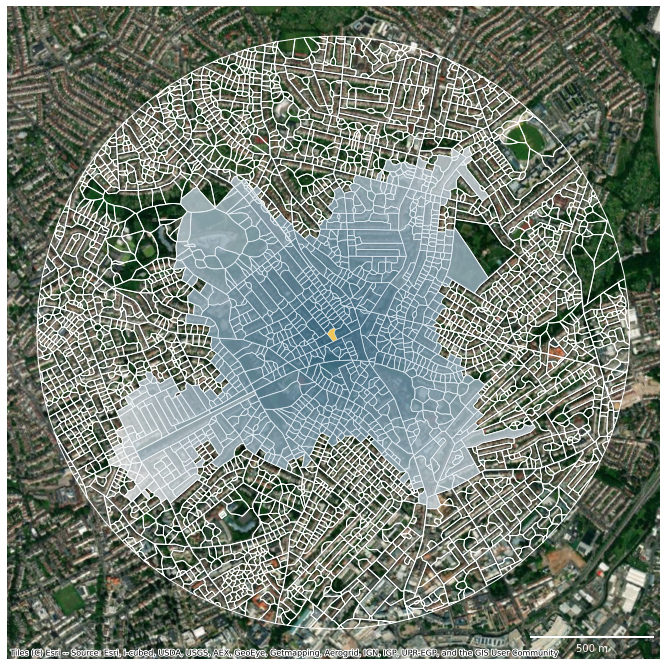

In [94]:
ax = subset.clip(Point((maxx+minx) / 2, (maxy+miny) / 2).buffer(1200)).plot(figsize=(12, 12), facecolor="none", edgecolor="w", linewidth=1)
central.plot(ax=ax, color=ugg.COLORS[4])
neighbors.plot("distance", ax=ax, cmap=sns.light_palette(ugg.COLORS[1], 256, as_cmap=True, reverse=True), edgecolor="w", linewidth=.5, alpha=.8)

# buildings.plot(ax=ax, color=ugg.COLORS[1], alpha=.1, zorder=-1)
ax.set_axis_off()

scalebar = ScaleBar(dx=1,
                    color="w",
                    location='lower right',
                    height_fraction=0.002,
                    pad=.5,
                    frameon=False,
                    )
ax.add_artist(scalebar)

contextily.add_basemap(ax=ax, source=contextily.providers.Esri.WorldImagery, crs=subset.crs)
plt.savefig("cell_context.png", dpi=150, bbox_inches="tight")

## Feature importance

In [6]:
importances = pandas.read_csv("../../urbangrammar_samba/spatial_signatures/clustering_data/spsig_feature_importance.csv", index_col=0)

In [7]:
importances.index = importances.index.map(renamer)

In [8]:
importances.columns = ["relative importance"]

In [24]:
print(importances.head(10).to_latex(longtable=True))

\begin{longtable}{lr}
\toprule
{} &  relative importance \\
\midrule
\endfirsthead

\toprule
{} &  relative importance \\
\midrule
\endhead
\midrule
\multicolumn{2}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
covered area ratio of ETC (Q1)             &             0.036944 \\
covered area ratio of ETC (Q2)             &             0.031717 \\
perimeter-weighted neighbours of ETC (Q2)  &             0.023476 \\
mean inter-building distance (Q2)          &             0.016662 \\
area of ETC (Q3)                           &             0.016005 \\
area covered by node-attached ETCs (Q3)    &             0.014813 \\
longest axis length of ETC (Q2)            &             0.014501 \\
weighted reached enclosures of ETC (Q1)    &             0.014115 \\
reached area by neighbouring segments (Q3) &             0.014000 \\
reached area by neighbouring segments (Q1) &             0.013904 \\
\end{longtable}



In [186]:
importances.head(10).sum()

relative importance    0.196135
dtype: float64

In [21]:
importances.to_excel("importances.xlsx")

In [13]:
type_imp = pandas.read_parquet("../../urbangrammar_samba/spatial_signatures/clustering_data/per_cluster_importance.pq")

In [14]:
classes = [
    'cluster_4', 'cluster_0', 'cluster_6', 'cluster_1', 'cluster_21',
    'cluster_7', 'cluster_3', 'cluster_5', 'cluster_90', 'cluster_20',
    'cluster_8', 'cluster_22', 'cluster_92', 'cluster_94', 'cluster_91',
    'cluster_95'
]
type_imp[classes] = type_imp[classes].apply(lambda x: x.map(renamer))

In [15]:
types = {
    0: "Countryside agriculture",
    1: "Accessible suburbia",
    3: "Open sprawl",
    4: "Wild countryside",
    5: "Warehouse/Park land",
    6: "Gridded residential quarters",
    7: "Urban buffer",
    8: "Disconnected suburbia",
    20: "Dense residential neighbourhoods",
    21: "Connected residential neighbourhoods",
    22: "Dense urban neighbourhoods",
    90: "Local urbanity",
    91: "Concentrated urbanity",
    92: "Regional urbanity",
    94: "Metropolitan urbanity",
    95: "Hyper concentrated urbanity",
    93: "outlier",
    96: "outlier",
    97: "outlier",
    98: "outlier",
}

In [16]:
tups = []
for c in type_imp.columns:
    if 'vals' in c:
        tups.append((types[int(c[8:-5])], 'rel. importance'))
    else:
        tups.append((types[int(c[8:])], 'name'))

In [17]:
type_imp.columns = pandas.MultiIndex.from_tuples(tups)

In [40]:
print(type_imp.iloc[:10].round(3).to_latex(longtable=True))

\begin{longtable}{llrlrlrlrlrlrlrlrlrlrlrlrlrlrlrlr}
\toprule
{} & \multicolumn{2}{l}{Wild countryside} & \multicolumn{2}{l}{Countryside agriculture} & \multicolumn{2}{l}{Gridded residential quarters} & \multicolumn{2}{l}{Accessible suburbia} & \multicolumn{2}{l}{Connected residential neighbourhoods} & \multicolumn{2}{l}{Urban buffer} & \multicolumn{2}{l}{Open sprawl} & \multicolumn{2}{l}{Warehouse/Park land} & \multicolumn{2}{l}{Local urbanity} & \multicolumn{2}{l}{Dense residential neighbourhoods} & \multicolumn{2}{l}{Disconnected suburbia} & \multicolumn{2}{l}{Dense urban neighbourhoods} & \multicolumn{2}{l}{Regional urbanity} & \multicolumn{2}{l}{Metropolitan urbanity} & \multicolumn{2}{l}{Concentrated urbanity} & \multicolumn{2}{l}{Hyper concentrated urbanity} \\
{} &                                               name & rel. importance &                                               name & rel. importance &                                               name & rel. importance &    

In [42]:
type_imp.iloc[:10].round(3).T

0  \
Wild countryside                     name                               longest axis length of ETC (Q1)   
                                     rel. importance                                              0.197   
Countryside agriculture              name                                covered area ratio of ETC (Q1)   
                                     rel. importance                                              0.154   
Gridded residential quarters         name                        local closeness of street network (Q3)   
                                     rel. importance                                              0.095   
Accessible suburbia                  name                       weighted reached enclosures of ETC (Q3)   
                                     rel. importance                                              0.064   
Connected residential neighbourhoods name                               cell alignment of building (Q1)   
                                     rel. importance                                              0.028   
Urban buffer                         name                       area covered by neighbouring cells (Q2)   
                                     rel. importance                                              0.072   
Open sprawl                          name                     reached area by local street network (Q1)   
                                     rel. importance                                              0.058   
Warehouse/Park land                  name                                   elongation of building (Q1)   
                                     rel. importance                                              0.034   
Local urbanity                       name                                    perimeter of building (Q2)   
                                     rel. importance                                              0.101   
Dense residential neighbourhoods     name              centroid - corner mean distance of building (Q2)   
                                     rel. importance                                              0.037   
Disconnected suburbia                name             local proportion of cul-de-sacs of street netw...   
                                     rel. importance                                              0.024   
Dense urban neighbourhoods           name                                    perimeter of building (Q2)   
                                     rel. importance                                              0.107   
Regional urbanity                    name             centroid - corner distance deviation of buildi...   
                                     rel. importance                                              0.115   
Metropolitan urbanity                name                 equivalent rectangular index of building (Q2)   
                                     rel. importance                                              0.111   
Concentrated urbanity                name                                         area of building (Q1)   
                                     rel. importance                                              0.128   
Hyper concentrated urbanity          name                                covered area ratio of ETC (Q2)   
                                     rel. importance                                              0.154   

                                                                                                      1  \
Wild countryside                     name                                covered area ratio of ETC (Q2)   
                                     rel. importance                                              0.151   
Countryside agriculture              name                                covered area ratio of ETC (Q2)   
                                     rel. importance                                              0.144   
Gridded residential quarters       

In [20]:
type_imp.to_excel("importances_type.xlsx")